## CI7000: Project Dissertation
### Machine Learning-Based Hybrid Sales Forecasting for Retail Financial Planning

>> Name: Pragati Priya

>> Student ID: K2461276

>> Date: 01/02/2026

Dataset: Superstore Sales Dataset, Kaggle. Available from https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting

## Installing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn.linear_model
import statsmodels.tsa.arima.model
import os
import optuna
import holidays

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet import Prophet
from prophet.make_holidays import make_holidays_df

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.model_selection import train_test_split

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random_seed = 42

## Loading and Cleaning Dataset

In [3]:
data = pd.read_csv(r"data.csv", sep=None, engine="python", on_bad_lines="error")
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [5]:
data.isnull().sum()

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

In [6]:
retail_data = data.copy()
retail_data

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9795,9796,CA-2017-125920,21/05/2017,28/05/2017,Standard Class,SH-19975,Sally Hughsby,Corporate,United States,Chicago,Illinois,60610.0,Central,OFF-BI-10003429,Office Supplies,Binders,"Cardinal HOLDit! Binder Insert Strips,Extra St...",3.7980
9796,9797,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,OFF-AR-10001374,Office Supplies,Art,"BIC Brite Liner Highlighters, Chisel Tip",10.3680
9797,9798,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10004977,Technology,Phones,GE 30524EE4,235.1880
9798,9799,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10000912,Technology,Phones,Anker 24W Portable Micro USB Car Charger,26.3760


In [7]:
retail_data["Postal Code"] = retail_data["Postal Code"].fillna(00000.0) # Filling with zeros as it wasn't feasible to locate the exact code.
retail_data.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
dtype: int64

## Date-time feature engineering

In [8]:
retail_data["Order Date"] = pd.to_datetime(retail_data["Order Date"], format="%d/%m/%Y", errors="coerce")
retail_data["Ship Date"] = pd.to_datetime(retail_data["Ship Date"], format="%d/%m/%Y", errors="coerce")
retail_data = retail_data.sort_values("Order Date").reset_index(drop=True) #sorted it by date
retail_data = retail_data.drop(columns=["index", "level_0"], errors="ignore") #removed unnecessary columns with similar info 

retail_data["Year"] = retail_data["Order Date"].dt.year
retail_data["Quarter"] = retail_data["Order Date"].dt.quarter
retail_data["Month"] = retail_data["Order Date"].dt.month
retail_data["Month_name"] = retail_data["Order Date"].dt.month_name()
retail_data["Day_of_month"] = retail_data["Order Date"].dt.day
retail_data["Day_of_year"] = retail_data["Order Date"].dt.dayofyear
retail_data["Day_of_week"] = retail_data["Order Date"].dt.weekday
retail_data["Weekday_name"] = retail_data["Order Date"].dt.day_name()
iso = retail_data["Order Date"].dt.isocalendar()
retail_data["Week_of_year"] = iso.week.astype(int)
retail_data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sales,Year,Quarter,Month,Month_name,Day_of_month,Day_of_year,Day_of_week,Weekday_name,Week_of_year
0,7981,CA-2015-103800,2015-01-03,2015-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,16.448,2015,1,1,January,3,3,5,Saturday,1
1,742,CA-2015-112326,2015-01-04,2015-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,3.540,2015,1,1,January,4,4,6,Sunday,1
2,741,CA-2015-112326,2015-01-04,2015-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,272.736,2015,1,1,January,4,4,6,Sunday,1
3,740,CA-2015-112326,2015-01-04,2015-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,11.784,2015,1,1,January,4,4,6,Sunday,1
4,1760,CA-2015-141817,2015-01-05,2015-01-12,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,...,19.536,2015,1,1,January,5,5,0,Monday,2


In [9]:
#adding cyclical features to week and month as it might be useful in the convergence rate of the algorithm and model perfomrance. 
retail_data["Dow_sin"] = np.sin(2*np.pi*retail_data["Day_of_week"]/7)
retail_data["Dow_cos"] = np.cos(2*np.pi*retail_data["Day_of_week"]/7)
retail_data["Month_sin"] = np.sin(2*np.pi*(retail_data["Month"]-1)/12)
retail_data["Month_coz"] = np.cos(2*np.pi*(retail_data["Month"]-1)/12)
retail_data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Month_name,Day_of_month,Day_of_year,Day_of_week,Weekday_name,Week_of_year,Dow_sin,Dow_cos,Month_sin,Month_coz
0,7981,CA-2015-103800,2015-01-03,2015-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,January,3,3,5,Saturday,1,-0.974928,-0.222521,0.0,1.0
1,742,CA-2015-112326,2015-01-04,2015-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,January,4,4,6,Sunday,1,-0.781831,0.623490,0.0,1.0
2,741,CA-2015-112326,2015-01-04,2015-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,January,4,4,6,Sunday,1,-0.781831,0.623490,0.0,1.0
3,740,CA-2015-112326,2015-01-04,2015-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,January,4,4,6,Sunday,1,-0.781831,0.623490,0.0,1.0
4,1760,CA-2015-141817,2015-01-05,2015-01-12,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,...,January,5,5,0,Monday,2,0.000000,1.000000,0.0,1.0


## Exploratory Data Analysis

In [10]:
retail_data["Sub-Category"].unique() #checking unique categories to explore hierarchical forecasting 

array(['Paper', 'Binders', 'Storage', 'Labels', 'Art', 'Phones', 'Chairs',
       'Fasteners', 'Furnishings', 'Accessories', 'Envelopes',
       'Bookcases', 'Appliances', 'Tables', 'Supplies', 'Machines',
       'Copiers'], dtype=object)

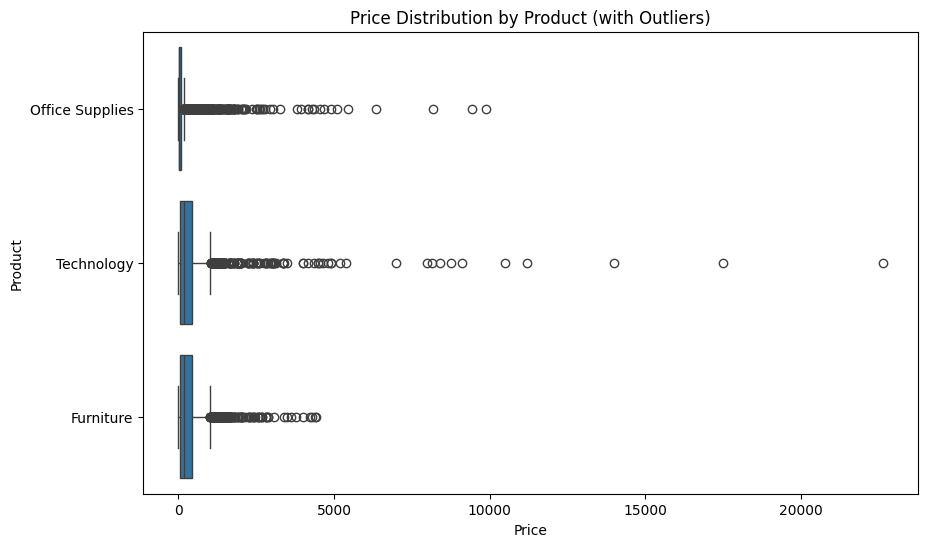

In [11]:
##Checking prcing distribution by category
plt.figure(figsize=(10,6))
sns.boxplot(x="Sales", y="Category", data=retail_data)
plt.title("Price Distribution by Product (with Outliers)")
plt.xlabel("Price"); plt.ylabel("Product"); plt.show()

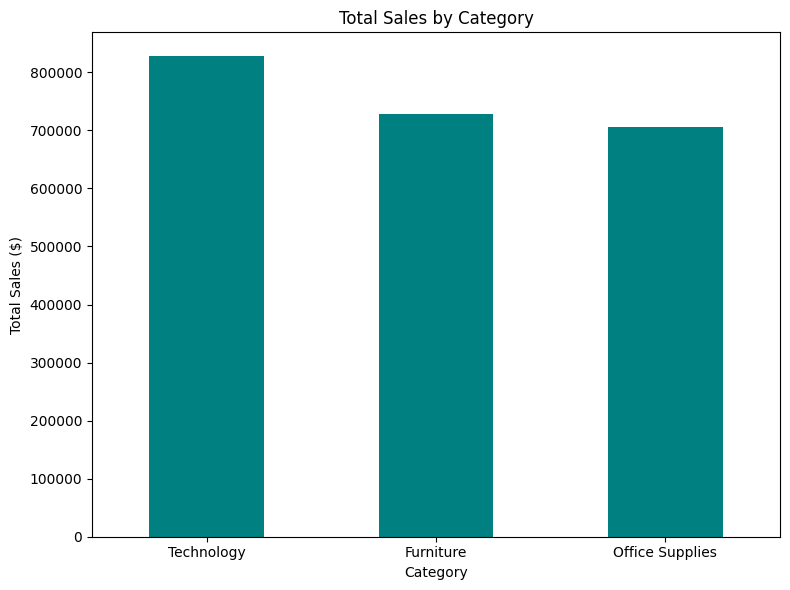

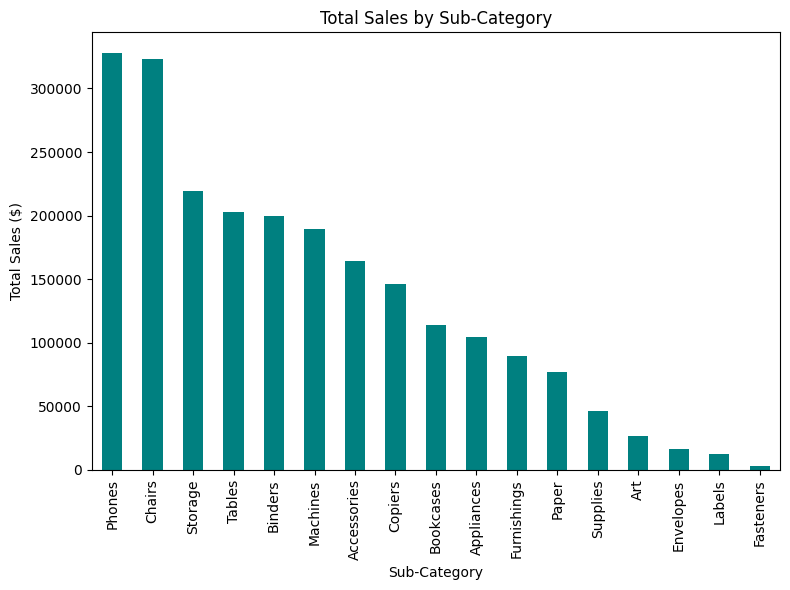

In [12]:
##Categorical sales analysis
category_sales = retail_data.groupby("Category")["Sales"].sum().sort_values(ascending=False)

plt.figure(figsize=(8,6))
category_sales.plot(kind="bar", color="teal")

plt.title("Total Sales by Category", fontsize=12)
plt.xlabel("Category", fontsize=10)
plt.ylabel("Total Sales ($)", fontsize=10)
plt.xticks(rotation=0); plt.tight_layout(); plt.show()

sub_category_sales = retail_data.groupby("Sub-Category")["Sales"].sum().sort_values(ascending=False)

plt.figure(figsize=(8,6))
sub_category_sales.plot(kind="bar", color="teal")

plt.title("Total Sales by Sub-Category", fontsize=12)
plt.xlabel("Sub-Category", fontsize=10)
plt.ylabel("Total Sales ($)", fontsize=10)
plt.xticks(rotation=90); plt.tight_layout(); plt.show()

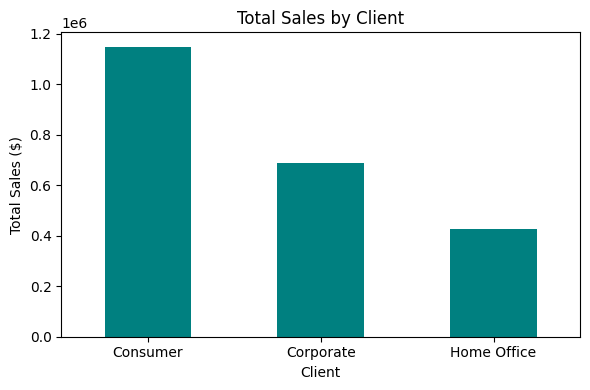

In [13]:
##Segment-based analysis
seg_sales = retail_data.groupby("Segment")["Sales"].sum().sort_values(ascending=False)

plt.figure(figsize=(6,4))
seg_sales.plot(kind="bar", color="teal")

plt.title("Total Sales by Client", fontsize=12)
plt.xlabel("Client", fontsize=10)
plt.ylabel("Total Sales ($)", fontsize=10)
plt.xticks(rotation=0); plt.tight_layout(); plt.show()

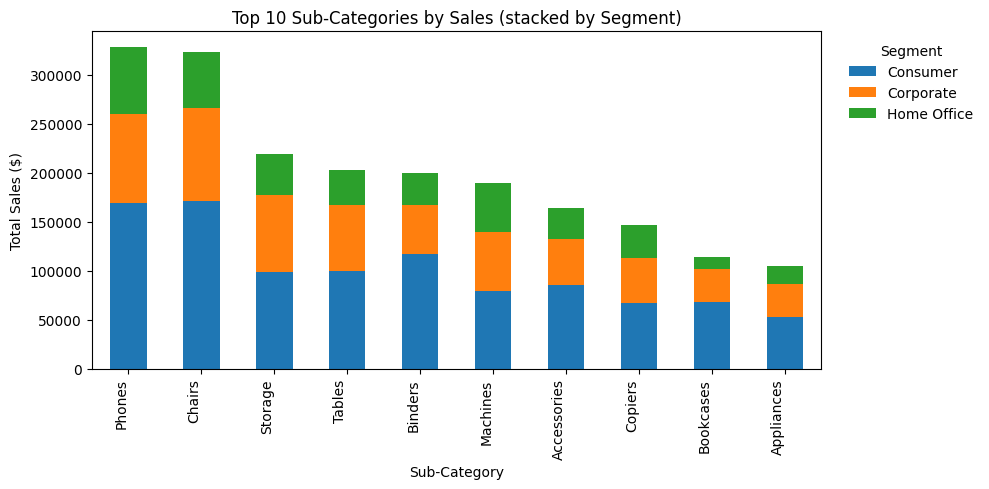

In [14]:
##Segment vise distribution across top 10 sub-categories
seg_sub = (retail_data.groupby(["Segment", "Sub-Category"], as_index=False)["Sales"].sum())
pivot = seg_sub.pivot(index="Sub-Category", columns="Segment", values="Sales").fillna(0)

top10 = pivot.assign(Total=pivot.sum(axis=1)).sort_values("Total", ascending=False).head(10)
top10 = top10.drop(columns="Total")

ax = top10.plot(kind="bar", stacked=True, figsize=(10,5))
ax.set_title("Top 10 Sub-Categories by Sales (stacked by Segment)")
ax.set_xlabel("Sub-Category")
ax.set_ylabel("Total Sales ($)")
ax.legend(title="Segment", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
plt.xticks(rotation=90, ha="right"); plt.tight_layout(); plt.show()

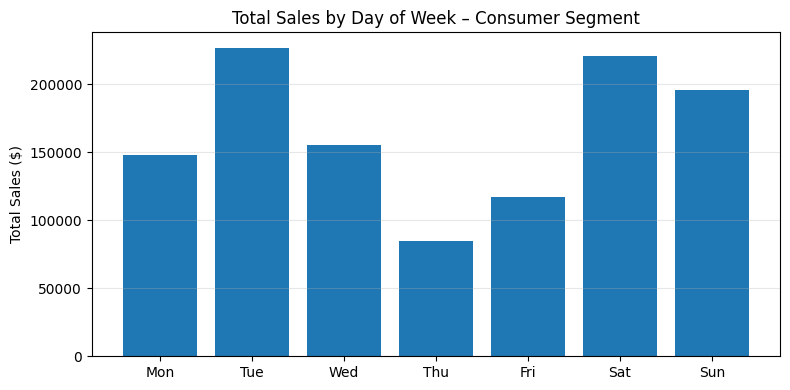

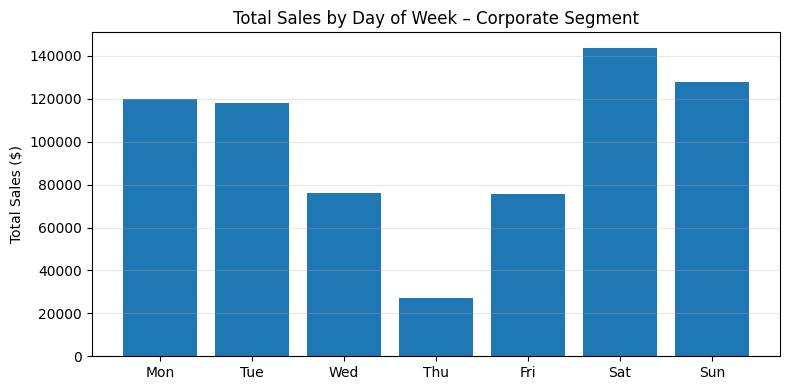

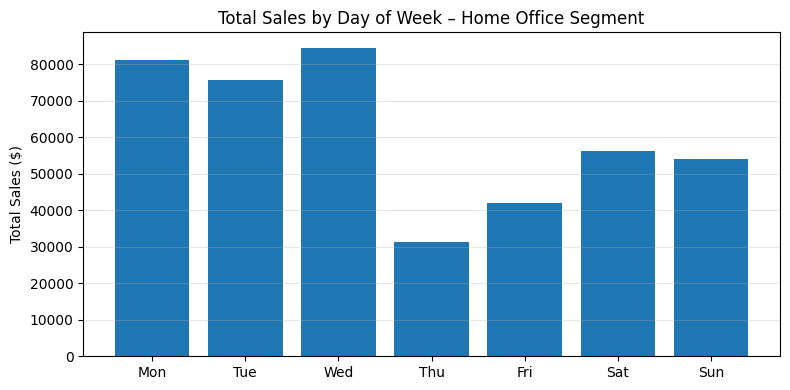

In [15]:
##Total sales by week per category

##Consumer
con_seg = retail_data[retail_data["Segment"] == "Consumer"].copy()
con_seg["dayofweek"] = con_seg["Order Date"].dt.dayofweek  # 0=Mon, 6=Sun
dow_ttl_con = con_seg.groupby("dayofweek")["Sales"].sum()

plt.figure(figsize=(8,4))
plt.bar(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], dow_ttl_con)
plt.title("Total Sales by Day of Week – Consumer Segment")
plt.ylabel("Total Sales ($)")
plt.grid(axis="y", alpha=0.3); plt.tight_layout(); plt.show()


##Corporate
corp_seg = retail_data[retail_data["Segment"] == "Corporate"].copy()
corp_seg["dayofweek"] = corp_seg["Order Date"].dt.dayofweek  
dow_ttl_corp = corp_seg.groupby("dayofweek")["Sales"].sum()

plt.figure(figsize=(8,4))
plt.bar(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], dow_ttl_corp)
plt.title("Total Sales by Day of Week – Corporate Segment")
plt.ylabel("Total Sales ($)")
plt.grid(axis="y", alpha=0.3); plt.tight_layout(); plt.show()


##Home Office
hf_seg = retail_data[retail_data["Segment"] == "Home Office"].copy()
hf_seg["dayofweek"] = hf_seg["Order Date"].dt.dayofweek  
dow_ttl_hf = hf_seg.groupby("dayofweek")["Sales"].sum()

plt.figure(figsize=(8,4))
plt.bar(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], dow_ttl_hf)
plt.title("Total Sales by Day of Week – Home Office Segment")
plt.ylabel("Total Sales ($)")
plt.grid(axis="y", alpha=0.3); plt.tight_layout(); plt.show()

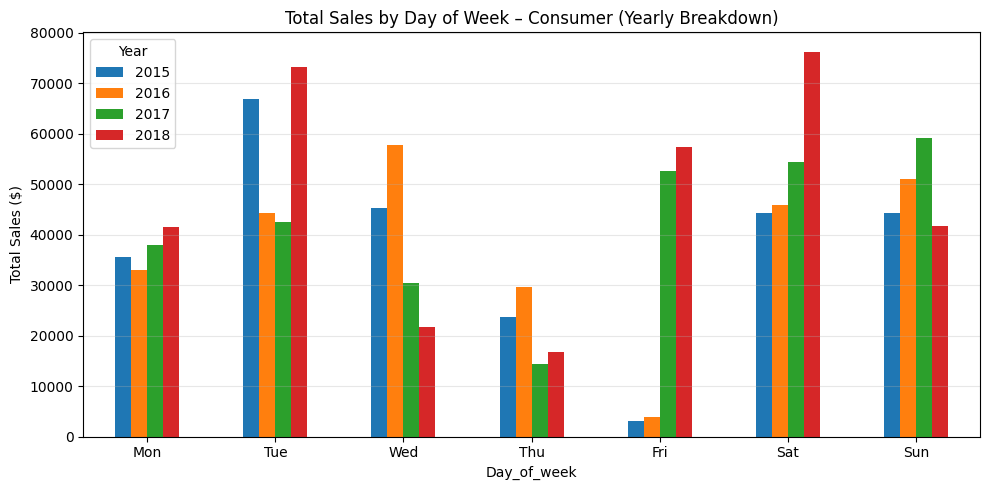

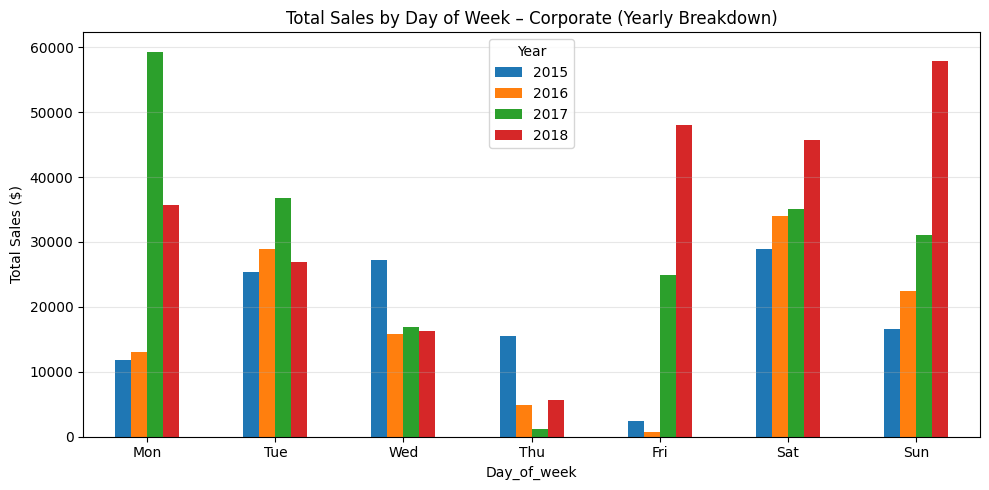

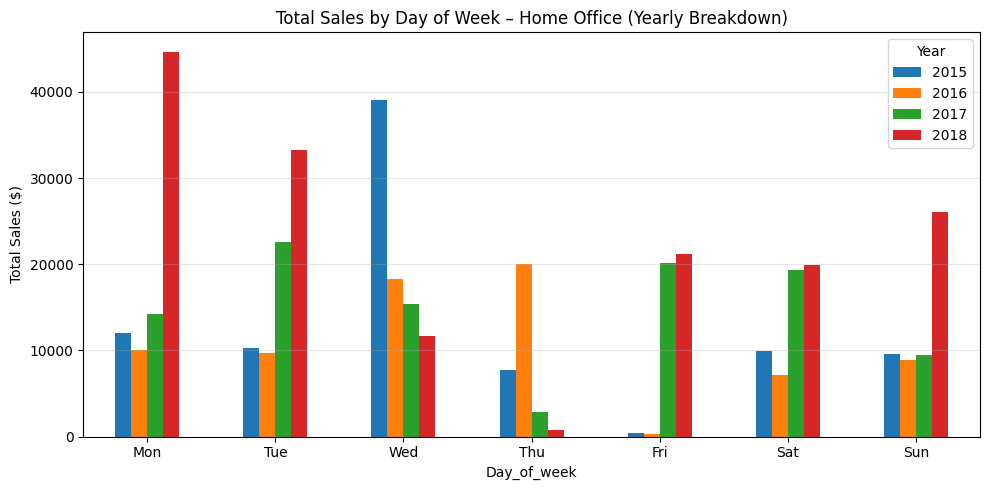

In [16]:
## Weekly Sales per segment broken down by years
def plot_dow_by_year(df, segment_name):
    dow_year = df.groupby(["Year", "Day_of_week"])["Sales"].sum().reset_index()
    pivot = dow_year.pivot(index="Day_of_week", columns="Year", values="Sales").fillna(0)

    ax = pivot.plot(kind="bar", figsize=(10,5))
    ax.set_xticks(range(7))
    ax.set_xticklabels(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"], rotation=0)

    plt.title(f"Total Sales by Day of Week – {segment_name} (Yearly Breakdown)")
    plt.ylabel("Total Sales ($)")
    plt.grid(axis="y", alpha=0.3); plt.tight_layout(); plt.show()

con_seg  = retail_data[retail_data["Segment"] == "Consumer"]
corp_seg = retail_data[retail_data["Segment"] == "Corporate"]
home_seg = retail_data[retail_data["Segment"] == "Home Office"]

plot_dow_by_year(con_seg, "Consumer")
plot_dow_by_year(corp_seg, "Corporate")
plot_dow_by_year(home_seg, "Home Office")

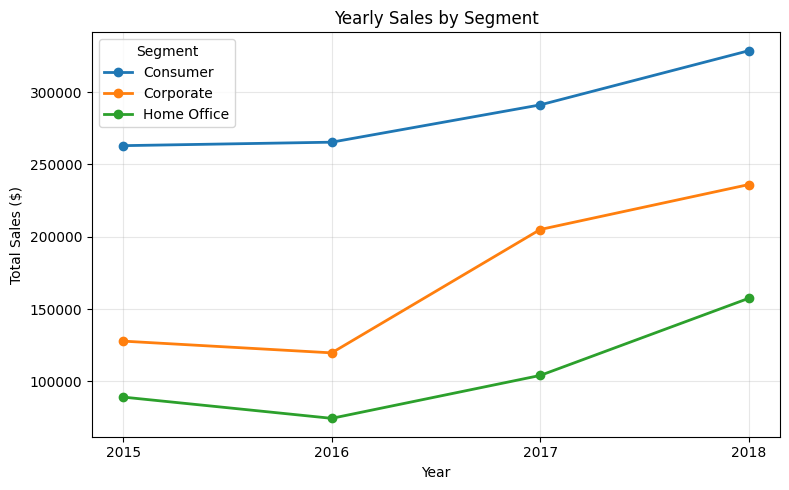

In [17]:
##Sales per segment across the years
seg_yearly = (retail_data.groupby(["Segment", "Year"], as_index=False)["Sales"].sum())
yearly_piv = seg_yearly.pivot(index="Year", columns="Segment", values="Sales")
yearly_piv.plot(marker="o", linewidth=2, figsize=(8,5))

plt.title("Yearly Sales by Segment")
plt.xlabel("Year")
plt.ylabel("Total Sales ($)")
plt.grid(True, alpha=0.3)
plt.xticks(yearly_piv.index);plt.tight_layout(); plt.show()

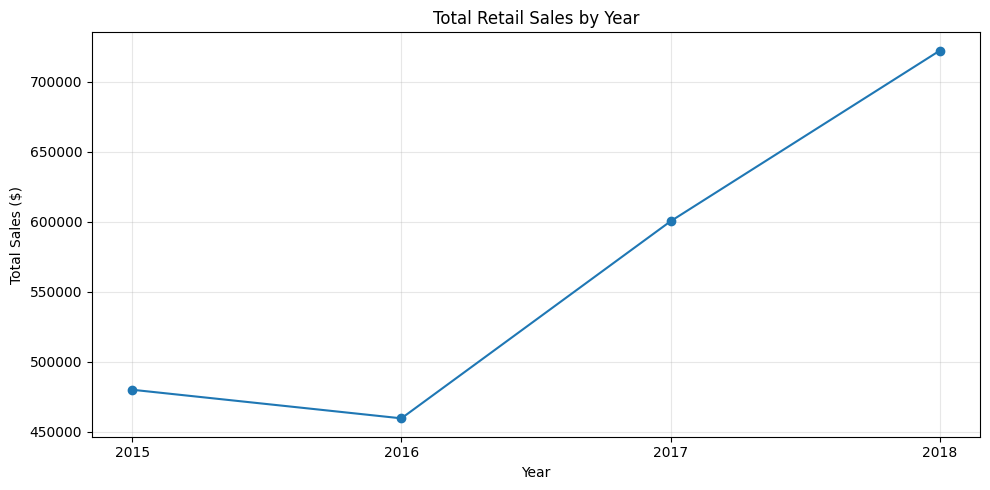

In [18]:
##Total sales tragectory
yearly_sales_graph = (retail_data.groupby("Year")["Sales"].sum())

plt.figure(figsize=(10, 5))
plt.plot(yearly_sales_graph.index, yearly_sales_graph.values, marker="o")

plt.title("Total Retail Sales by Year")
plt.xlabel("Year")
plt.ylabel("Total Sales ($)")
plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.xticks(yearly_piv.index); plt.show()

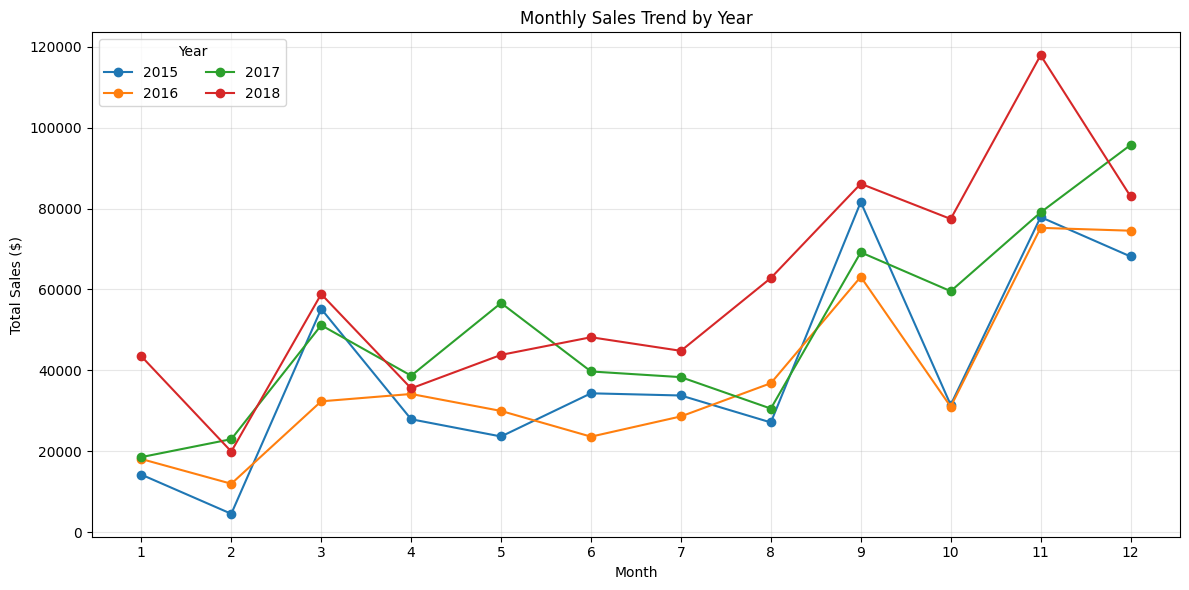

In [19]:
##Sales trend by month across the years
monthly_sales_graph = (retail_data.groupby(["Year", "Month"])["Sales"].sum().reset_index())

plt.figure(figsize=(12, 6))

for year, grp in monthly_sales_graph.groupby("Year"):
    plt.plot(grp["Month"], grp["Sales"], marker="o", label=str(year))

plt.title("Monthly Sales Trend by Year")
plt.xlabel("Month")
plt.ylabel("Total Sales ($)")
plt.xticks(range(1, 13))
plt.legend(title="Year", ncol=2)
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

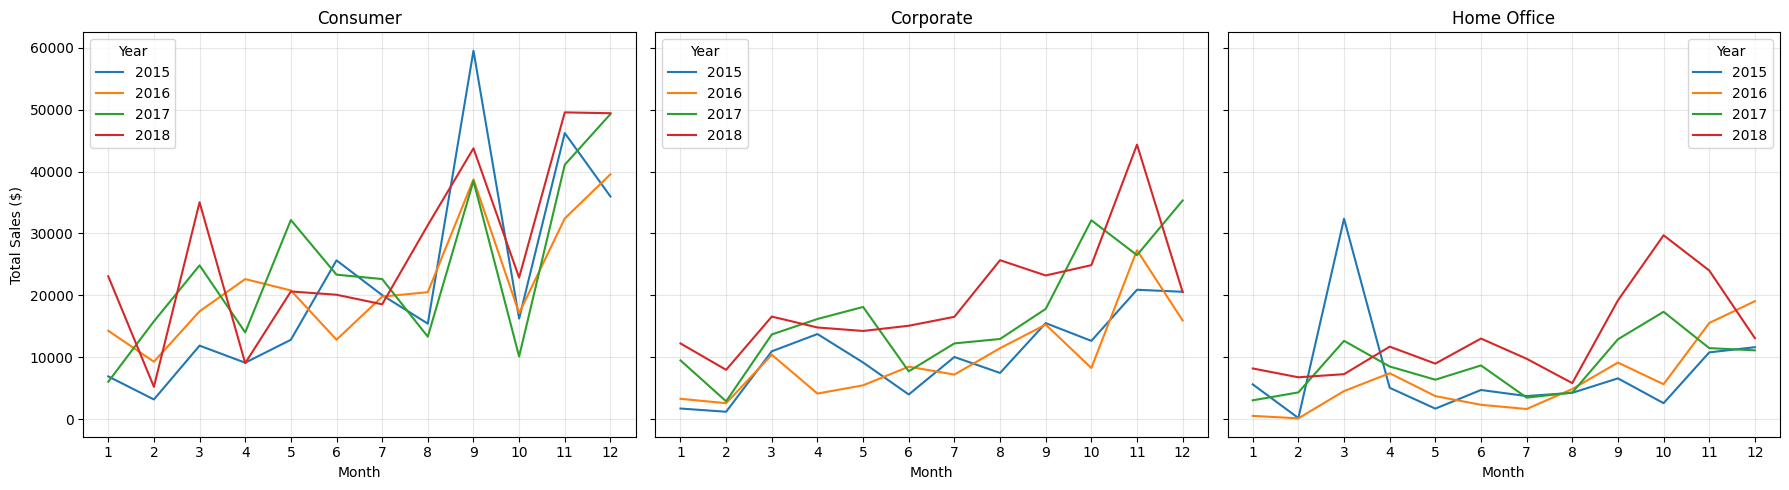

In [20]:
##Segment vise distribution across months
seg_monthly = (retail_data.groupby(["Segment", "Year", "Month"], as_index=False)["Sales"].sum())
segments_m = seg_monthly["Segment"].unique()
fig, axes = plt.subplots(1, len(segments_m), figsize=(6*len(segments_m), 5), sharey=True)

if len(segments_m) == 1:
    axes = [axes]

for ax, seg in zip(axes, segments_m):
    d = seg_monthly[seg_monthly["Segment"] == seg]
    piv = d.pivot(index="Month", columns="Year", values="Sales")
    piv.plot(ax=ax)
    ax.set_title(f"{seg}")
    ax.set_xlabel("Month"); ax.set_ylabel("Total Sales ($)")
    ax.grid(True, alpha=0.3); ax.set_xticks(range(1,13))

plt.tight_layout(); plt.show()

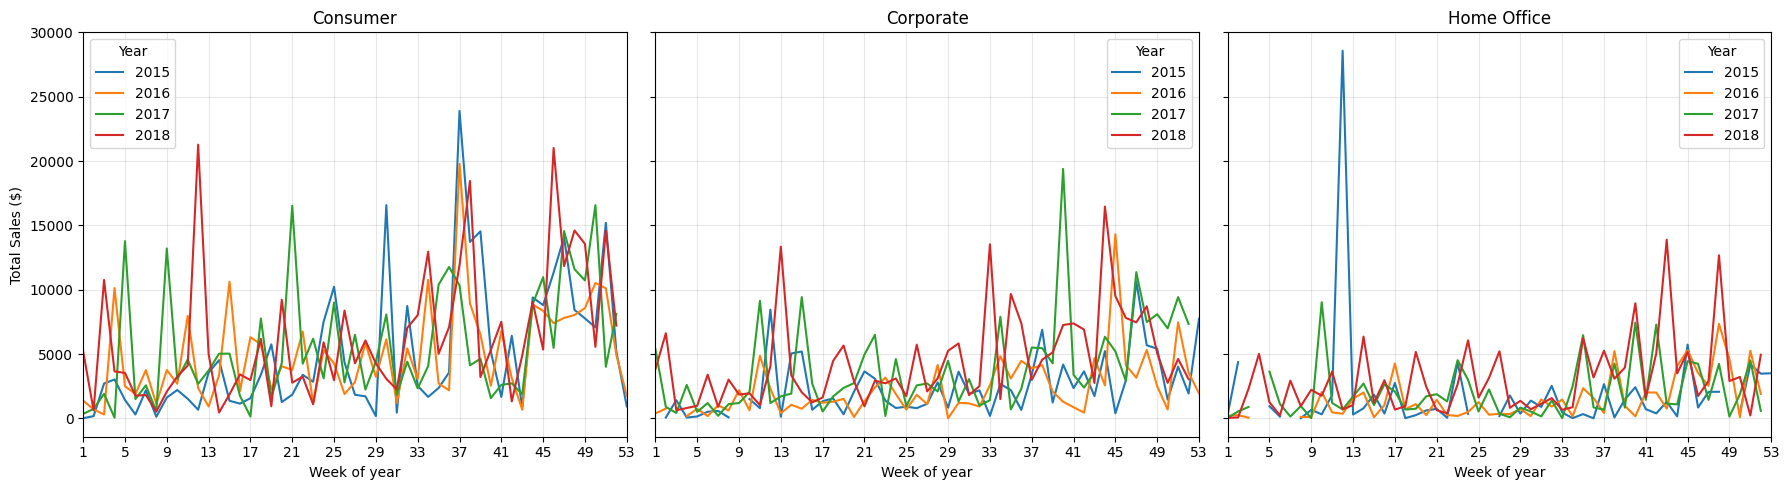

In [21]:
##Segment vise distribution across weeks
seg_weekly = (retail_data.groupby(["Segment", "Year", "Week_of_year"], as_index=False)["Sales"].sum())

segments_w = seg_weekly["Segment"].unique()
fig, axes = plt.subplots(1, len(segments_w), figsize=(6*len(segments_w), 5), sharey=True)

if len(segments_w) == 1:
    axes = [axes]

for ax, seg in zip(axes, segments_w):
    b = seg_weekly[seg_weekly["Segment"] == seg]
    piv = b.pivot(index="Week_of_year", columns="Year", values="Sales")
    piv = piv.reindex(range(1, 54), fill_value=0)
    piv.plot(ax=ax)
    ax.set_title(f"{seg}")
    ax.set_xlabel("Week of year"); ax.set_ylabel("Total Sales ($)")
    ax.set_xlim(1, 53)
    ax.grid(True, alpha=0.3); ax.set_xticks(range(1, 54, 4))

plt.tight_layout(); plt.show()

>> it's interesting to see the gaps here, showcasing no trade for a segment that week

/var/folders/qw/q7626nwn3h97_4rct7m6kw4h0000gn/T/ipykernel_16042/664364122.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.xlabel("Days"); plt.ylabel("Orders"); plt.legend(); plt.tight_layout(); plt.show()


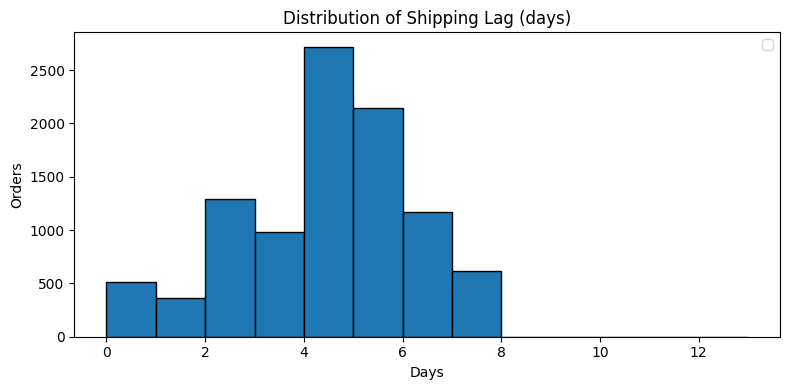

In [22]:
##Analysing Shipping behaviour
retail_data["ship_lag_days"] = (retail_data["Ship Date"] - retail_data["Order Date"]).dt.days
plt.figure(figsize=(8,4))
plt.hist(retail_data["ship_lag_days"], bins=range(0, 14), edgecolor="black")
plt.title("Distribution of Shipping Lag (days)")
plt.xlabel("Days"); plt.ylabel("Orders"); plt.legend(); plt.tight_layout(); plt.show()

<Figure size 800x400 with 0 Axes>

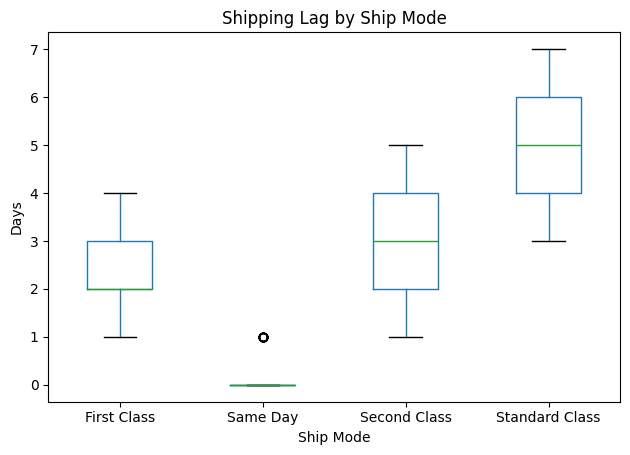

<Figure size 800x400 with 0 Axes>

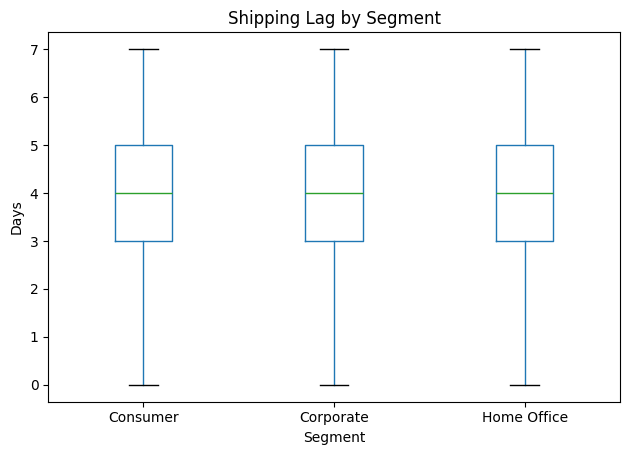

In [23]:
## By Ship Mode
plt.figure(figsize=(8,4))
retail_data.boxplot(column="ship_lag_days", by="Ship Mode", grid=False)
plt.title("Shipping Lag by Ship Mode"); plt.suptitle("")
plt.xlabel("Ship Mode"); plt.ylabel("Days")
plt.tight_layout(); plt.show()

## By Segment
plt.figure(figsize=(8,4))
retail_data.boxplot(column="ship_lag_days", by="Segment", grid=False)
plt.title("Shipping Lag by Segment"); plt.suptitle("")
plt.xlabel("Segment"); plt.ylabel("Days")
plt.tight_layout(); plt.show()

In [24]:
retail_data.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Year', 'Quarter', 'Month', 'Month_name',
       'Day_of_month', 'Day_of_year', 'Day_of_week', 'Weekday_name',
       'Week_of_year', 'Dow_sin', 'Dow_cos', 'Month_sin', 'Month_coz',
       'ship_lag_days'],
      dtype='object')

In [25]:
##Repeat orders per customer ##
repeat_counts = retail_data.groupby("Customer ID")["Order Date"].count()
repeat_counts = repeat_counts[repeat_counts > 1]  
print(repeat_counts)


Customer ID
AA-10315    11
AA-10375    15
AA-10480    12
AA-10645    18
AB-10015     6
            ..
XP-21865    28
YC-21895     8
YS-21880    12
ZC-21910    31
ZD-21925     9
Name: Order Date, Length: 787, dtype: int64


## Trend Analysis

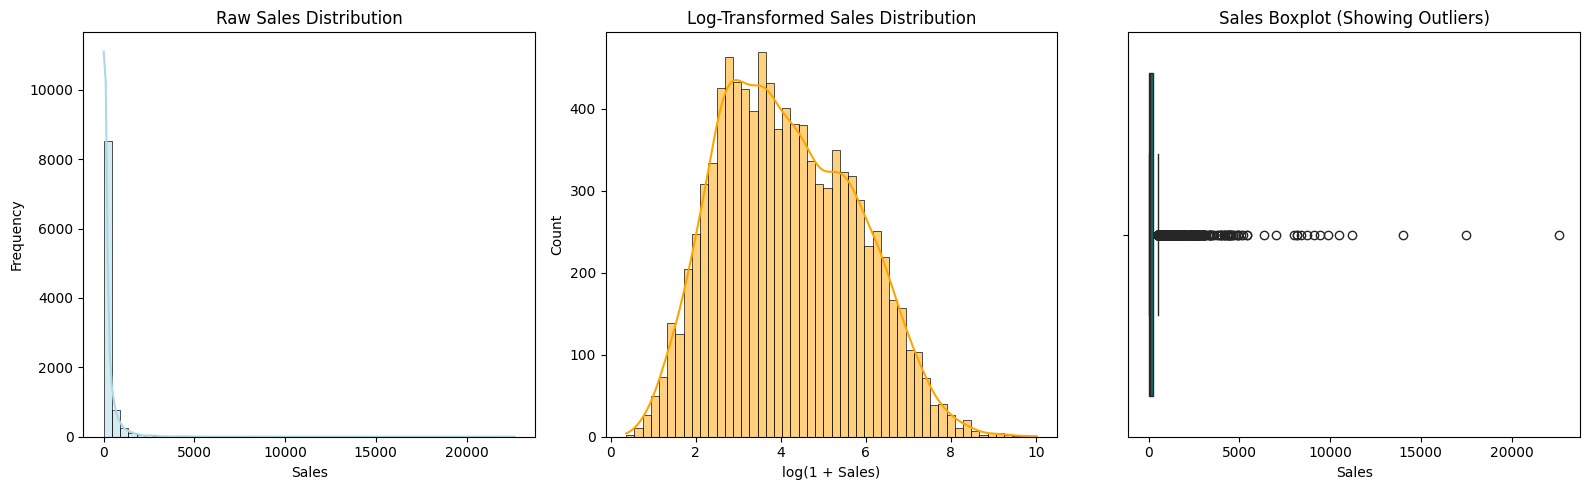

In [26]:
#Sales distribution
plt.figure(figsize=(16,5))

# Raw Sales
plt.subplot(1, 3, 1)
sns.histplot(retail_data["Sales"], bins=50, kde=True, color="lightblue")
plt.title("Raw Sales Distribution")
plt.xlabel("Sales")
plt.ylabel("Frequency")

# Log-transformed Sales 
plt.subplot(1, 3, 2)
sns.histplot(np.log1p(retail_data["Sales"]), bins=50, kde=True, color="orange")
plt.title("Log-Transformed Sales Distribution")
plt.xlabel("log(1 + Sales)")

# Outliers
plt.subplot(1, 3, 3)
sns.boxplot(x=retail_data["Sales"], color="teal")
plt.title("Sales Boxplot (Showing Outliers)")
plt.xlabel("Sales")

plt.tight_layout()
plt.show()


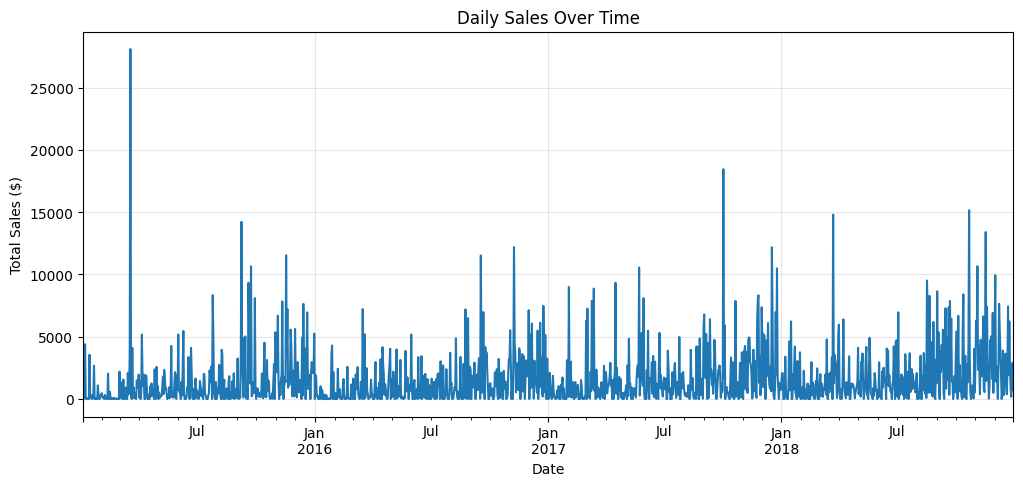

In [27]:
## DAILY SAMPLING ##
##Stationarity Check
sales_data = retail_data.groupby("Order Date")["Sales"].sum().asfreq("D").fillna(0)

plt.figure(figsize=(12, 5))
sales_data.plot()
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales ($)"); plt.grid(True, alpha=0.3); plt.show()



In [28]:
##ADF Test

adf_result = adfuller(sales_data.dropna())

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value}")

ADF Statistic: -4.9265833751962465
p-value: 3.094891245873504e-05
Critical Value (1%): -3.434908816804013
Critical Value (5%): -2.863553406963303
Critical Value (10%): -2.5678419239852994


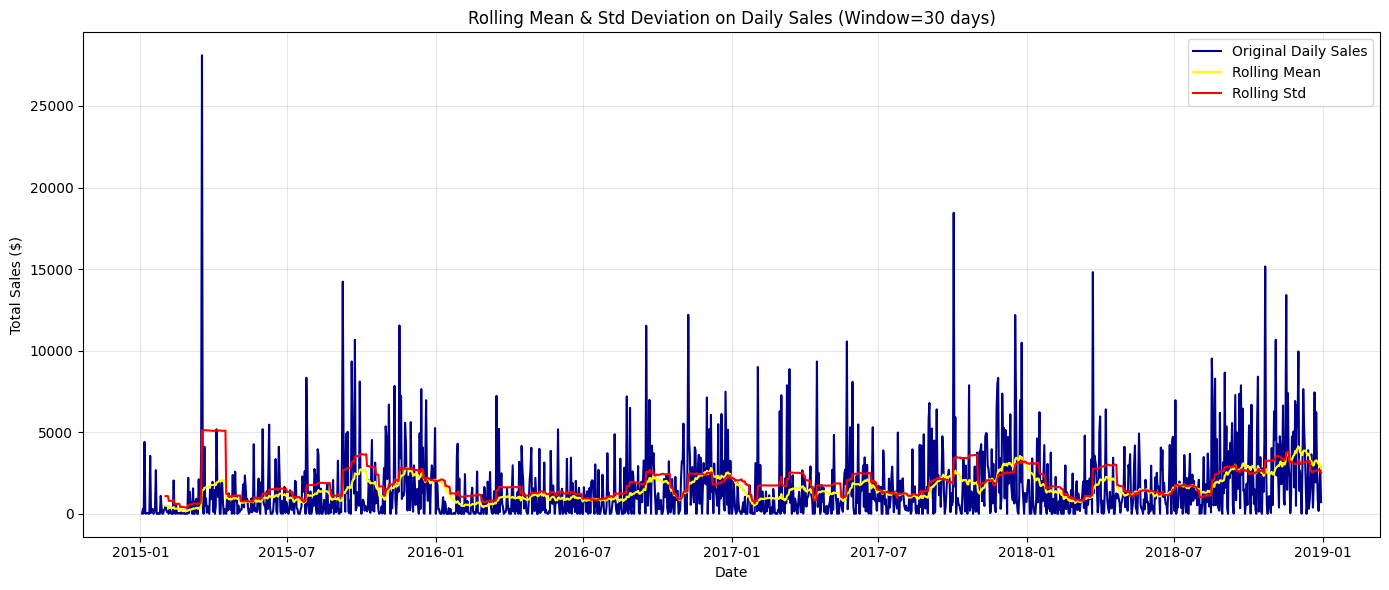

In [29]:
##Rolling Mean and Std Checks 
def check_mean_std(ts, window=30):
    rolmean = ts.rolling(window=window).mean()
    rolstd = ts.rolling(window=window).std()

    plt.figure(figsize=(14, 6))
    plt.plot(ts, color='darkblue', label='Original Daily Sales')         
    plt.plot(rolmean, color='yellow', label='Rolling Mean')  
    plt.plot(rolstd, color='red', label='Rolling Std')   
    plt.title(f'Rolling Mean & Std Deviation on Daily Sales (Window={window} days)')
    plt.xlabel('Date')
    plt.ylabel('Total Sales ($)')
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

check_mean_std(sales_data.dropna())

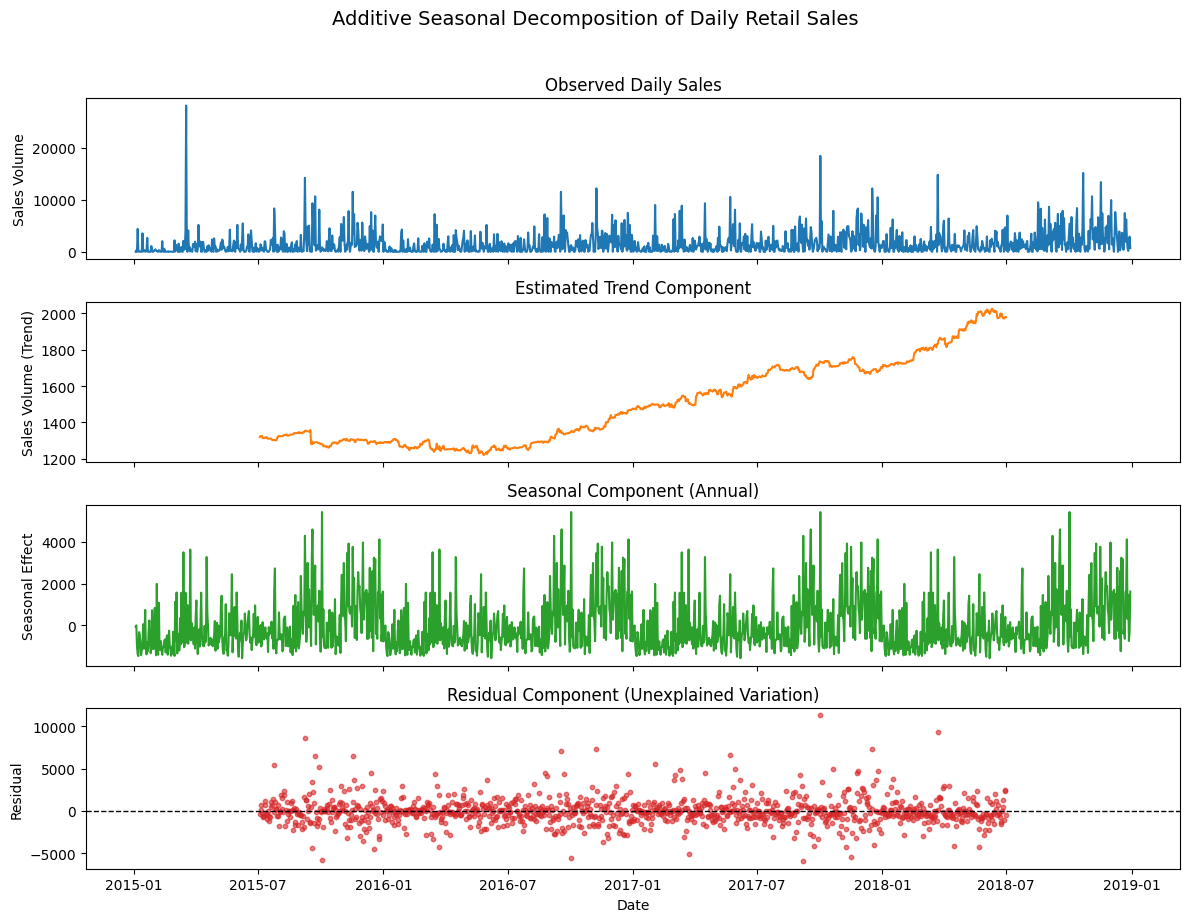

In [30]:
##Seaonal Decomposition

decomp = seasonal_decompose(sales_data.dropna(), model='additive', period=365)
fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)

# Observed
axes[0].plot(decomp.observed, color="tab:blue")
axes[0].set_title("Observed Daily Sales")
axes[0].set_ylabel("Sales Volume")

# Trend
axes[1].plot(decomp.trend, color="tab:orange")
axes[1].set_title("Estimated Trend Component")
axes[1].set_ylabel("Sales Volume (Trend)")

# Seasonal
axes[2].plot(decomp.seasonal, color="tab:green")
axes[2].set_title("Seasonal Component (Annual)")
axes[2].set_ylabel("Seasonal Effect")

# Residual
axes[3].scatter(decomp.resid.index, decomp.resid, s=10, alpha=0.6, color="tab:red")
axes[3].axhline(0, linestyle="--", color="black", linewidth=1)
axes[3].set_title("Residual Component (Unexplained Variation)")
axes[3].set_ylabel("Residual")
axes[3].set_xlabel("Date")

plt.suptitle("Additive Seasonal Decomposition of Daily Retail Sales",
    fontsize=14,
    y=1.02)

plt.tight_layout(); plt.show()


# MODEL BUILDING

## ARIMA

In [31]:
eps = 1e-6

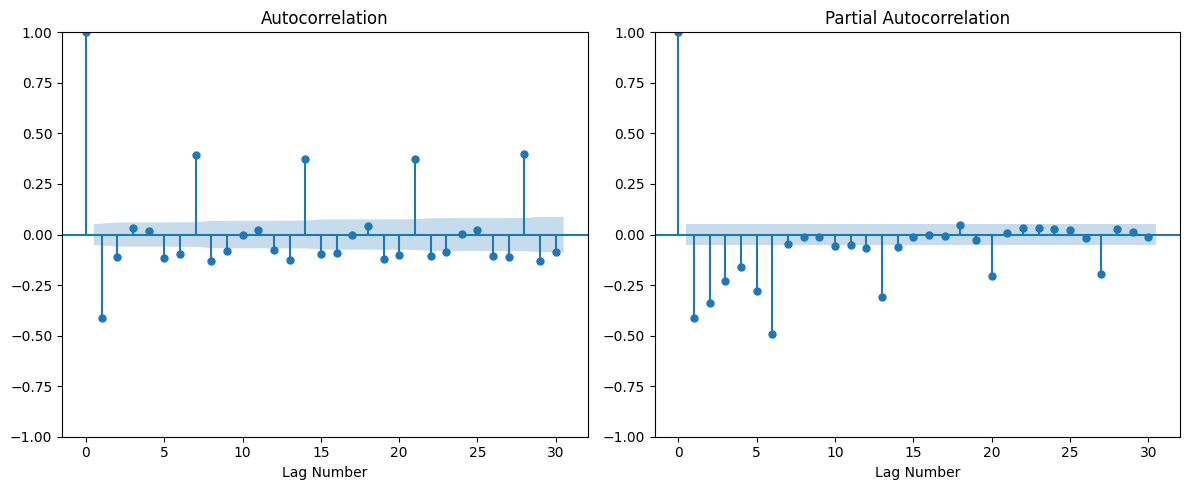

In [32]:
##Preprocessing for ARIMA
sales_log = np.log1p(sales_data) #np.log crashes with 0 values
diff_sales = sales_log.diff().dropna()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plot_acf(diff_sales, ax=plt.gca(), lags=30)
plt.xlabel("Lag Number")

plt.subplot(1,2,2)
plot_pacf(diff_sales, ax=plt.gca(), lags=30)
plt.xlabel("Lag Number")
plt.tight_layout(); plt.show()


In [33]:
##ARIMA train, test, fit

train_size = int(len(diff_sales)*0.8)
train, test = diff_sales[:train_size], diff_sales[train_size:]
model = ARIMA(train, order=(1,0,1)) #on differenced data

model_fit = model.fit()
print(model_fit.summary())

fcst_diff = model_fit.get_forecast(steps=len(test)).predicted_mean
fcst_diff.index = test.index

baseline_pos = sales_log.index.get_loc(test.index[0]) - 1
last_log = sales_log.iloc[baseline_pos]
fcst_log = last_log + fcst_diff.cumsum()
true_log = sales_log.loc[fcst_log.index]

y_true = np.expm1(true_log)
y_pred = np.expm1(fcst_log)

## Evaludation ##

nonzero = y_true > eps
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])) * 100
mpe  = np.mean((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero]) * 100

print("=== ARIMA (trained on log-diffs, evaluated on original sales) ===")
print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"MPE : {mpe:.2f}%")

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                 1165
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2854.572
Date:                Sun, 01 Feb 2026   AIC                           5717.143
Time:                        20:18:50   BIC                           5737.385
Sample:                    01-04-2015   HQIC                          5724.779
                         - 03-13-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.005      0.310      0.756      -0.008       0.011
ar.L1          0.0697      0.031      2.286      0.022       0.010       0.130
ma.L1         -0.9619      0.008   -120.942      0.0

## SARIMA

In [34]:
##SARIMA train, test, fit
train_size_sa = int(len(sales_log)*0.8) 
train_sa, test_sa = sales_log[:train_size_sa], sales_log[train_size_sa:]

model_sa = SARIMAX(train_sa, order=(1,1,2), seasonal_order=(1,1,1,7))
model_sa_fit = model_sa.fit(disp=False)

print(model_sa_fit.summary())

fcst_log_sa = model_sa_fit.get_forecast(steps=len(test_sa)).predicted_mean
fcst_log_sa.index = test_sa.index

y_true_sa = np.expm1(test_sa)
y_pred_sa = np.expm1(fcst_log_sa)

## Evaludation ##

nonzero_sa = y_true_sa > eps
rmse_sa = np.sqrt(mean_squared_error(y_true_sa, y_pred_sa))
mae_sa  = mean_absolute_error(y_true_sa, y_pred_sa)
mape_sa = np.mean(np.abs((y_true_sa[nonzero_sa] - y_pred_sa[nonzero_sa]) / y_true_sa[nonzero_sa])) * 100
mpe_sa  = np.mean((y_true_sa[nonzero_sa] - y_pred_sa[nonzero_sa]) / y_true_sa[nonzero_sa]) * 100

print("=== SARIMA (trained on log-diffs, evaluated on original sales) ===")
print(f"MAE : {mae_sa:,.2f}")
print(f"RMSE: {rmse_sa:,.2f}")
print(f"MAPE: {mape_sa:.2f}%")
print(f"MPE : {mpe_sa:.2f}%")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                 1166
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 7)   Log Likelihood               -2622.926
Date:                             Sun, 01 Feb 2026   AIC                           5257.851
Time:                                     20:18:51   BIC                           5288.178
Sample:                                 01-03-2015   HQIC                          5269.295
                                      - 03-13-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5589      0.510      1.096      0.273      -0.441       1.558
ma.L1         -1.4655      

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Prophet

####################################
### Random Split - Prophet Baseline ###
####################################

/var/folders/qw/q7626nwn3h97_4rct7m6kw4h0000gn/T/ipykernel_16042/3093137596.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sales_ppt = (retail_data.set_index("Order Date").resample("M")["Sales"].sum()
20:18:52 - cmdstanpy - INFO - Chain [1] start processing
20:18:52 - cmdstanpy - INFO - Chain [1] done processing


=== Baseline Prophet Results Based on Random Temporal Split ===
MAE : 11,259.07
RMSE: 14,044.12
MAPE: 39.46%
MPE : -3.29%


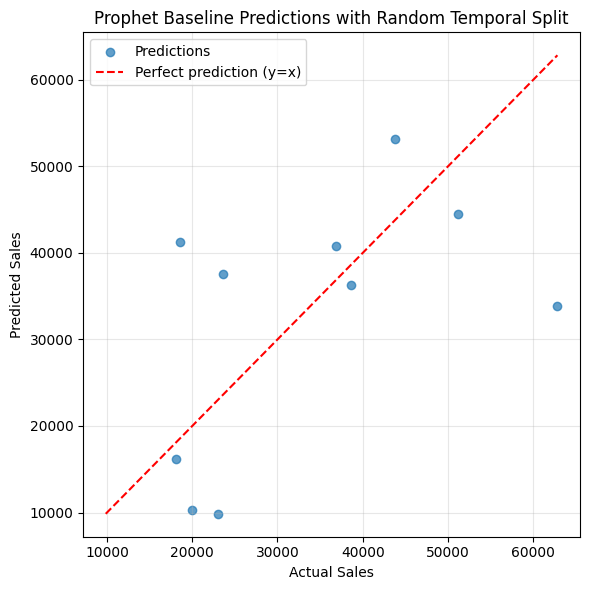

In [35]:
## Monthly Aggregate Sales for all Prophet models 
sales_ppt = (retail_data.set_index("Order Date").resample("M")["Sales"].sum()
                   .reset_index()
                   .rename(columns={"Order Date": "ds", "Sales": "y"}))

train_ppt, test_ppt = train_test_split(sales_ppt,test_size=0.2, shuffle=True,random_state=random_seed)

train_ppt = train_ppt.sort_values("ds")
test_ppt  = test_ppt.sort_values("ds")

model_ppt = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.09)

model_ppt.fit(train_ppt)
fcst_ppt = model_ppt.predict(test_ppt[["ds"]])

pred_ppt = (fcst_ppt.set_index("ds").loc[test_ppt["ds"], "yhat"].rename("yhat"))

y_true = test_ppt["y"].values
y_pred = fcst_ppt["yhat"].values

## Evaludation ##

mae_ppt  = mean_absolute_error(y_true, y_pred)
rmse_ppt = np.sqrt(mean_squared_error(y_true, y_pred))
mape_ppt = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mpe_ppt  = np.mean((y_true - y_pred) / y_true) * 100

print(f"=== Baseline Prophet Results Based on Random Temporal Split ===")
print(f"MAE : {mae_ppt:,.2f}")
print(f"RMSE: {rmse_ppt:,.2f}")
print(f"MAPE: {mape_ppt:.2f}%")
print(f"MPE : {mpe_ppt:.2f}%")

## Plot ##

min_v = min(np.min(y_true), np.min(y_pred))
max_v = max(np.max(y_true), np.max(y_pred))
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.7, label="Predictions")
plt.plot([min_v, max_v], [min_v, max_v], "r--", label="Perfect prediction (y=x)")

plt.title("Prophet Baseline Predictions with Random Temporal Split")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.legend();plt.grid(alpha=0.3);plt.tight_layout();plt.show()

########################################
### Row-based 80/ 20 - Prophet Baseline ###
########################################

20:18:52 - cmdstanpy - INFO - Chain [1] start processing
20:18:52 - cmdstanpy - INFO - Chain [1] done processing


=== Baseline Prophet Results Based on Row-Based 80/20 Split ===
MAE : 12,086.54
RMSE: 15,356.66
MAPE: 17.09%
MPE: 4.54%


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


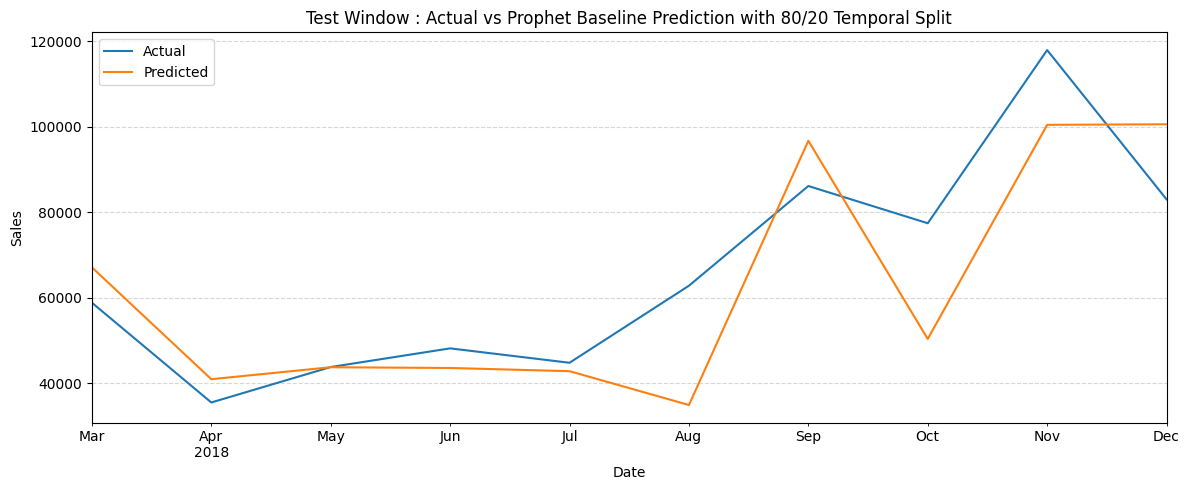

In [36]:
split_point = int(len(sales_ppt)*0.8)
train_ppt = sales_ppt.iloc[:split_point]
test_ppt = sales_ppt.iloc[split_point:]

model_ppt = Prophet(
    yearly_seasonality=True, 
    weekly_seasonality=False,  
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.09)

model_ppt.fit(train_ppt)
future_ppt = model_ppt.make_future_dataframe(periods=len(test_ppt), freq="M", include_history=True)
fcst_ppt = model_ppt.predict(future_ppt)

pred_ppt = (fcst_ppt.set_index("ds").loc[test_ppt["ds"], "yhat"].rename("yhat"))

## Evaludation ##

mask = test_ppt["y"] != 0 
actuals = test_ppt.loc[mask, "y"].values
preds = pred_ppt.loc[test_ppt.loc[mask, "ds"]].values

mae_ppt  = mean_absolute_error(actuals, preds)
rmse_ppt = np.sqrt(((actuals - preds) ** 2).mean())
mape_ppt = np.mean(np.abs((actuals - preds) / actuals)) * 100
mpe_ppt = np.mean((actuals - preds) / actuals) * 100

print(f"=== Baseline Prophet Results Based on Row-Based 80/20 Split ===")
print(f"MAE : {mae_ppt:,.2f}")
print(f"RMSE: {rmse_ppt:,.2f}")
print(f"MAPE: {mape_ppt:,.2f}%")
print(f"MPE: {mpe_ppt:,.2f}%")

## Plot ##

ax = test_ppt.set_index("ds")["y"].plot(figsize=(12,5), label="Actual")
pred_ppt.plot(ax=ax, label="Predicted")
plt.title("Test Window : Actual vs Prophet Baseline Prediction with 80/20 Temporal Split")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend(); plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()


########################################
### Year-Based 75/25 - Prophet Baseline ###
########################################

20:18:52 - cmdstanpy - INFO - Chain [1] start processing
20:18:52 - cmdstanpy - INFO - Chain [1] done processing
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


=== Baseline Prophet Results Based on Year-Based 75/25 Split ===
MAE : 12,340.15
RMSE: 15,600.55
MAPE: 21.01%
MPE: 12.67%


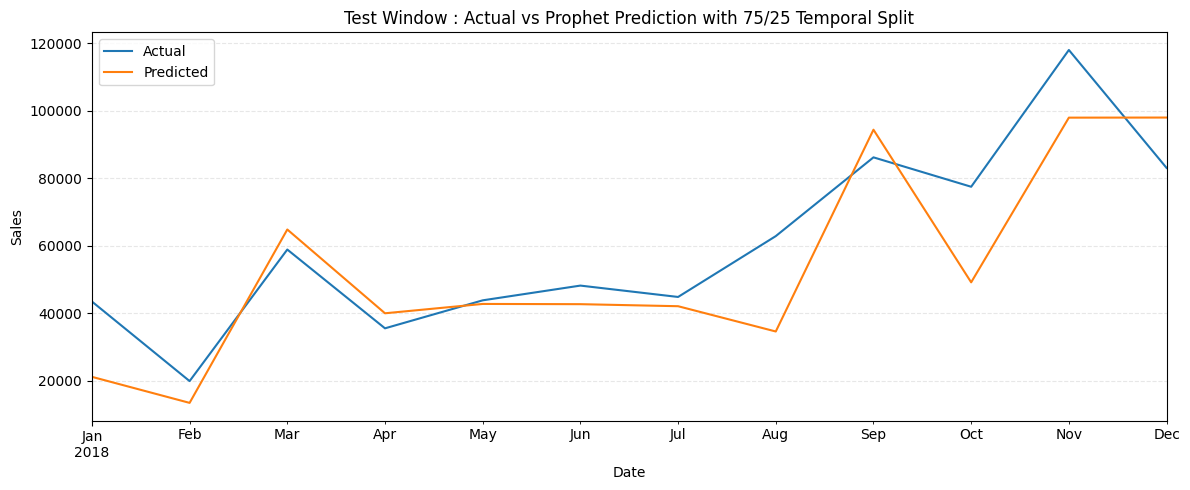

In [37]:
train_ppt = sales_ppt[sales_ppt["ds"].dt.year <= 2017]
test_ppt  = sales_ppt[sales_ppt["ds"].dt.year >= 2018]

train_ppt = train_ppt.sort_values("ds")
test_ppt = test_ppt.sort_values("ds")

model_ppt = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,  
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.09)

model_ppt.fit(train_ppt)

future_ppt = model_ppt.make_future_dataframe(periods=len(test_ppt), freq="M", include_history=True)
fcst_ppt = model_ppt.predict(future_ppt)

pred_ppt = (fcst_ppt.set_index("ds").loc[test_ppt["ds"], "yhat"].rename("yhat"))

## Evaluaion ##

mask = test_ppt["y"] != 0 
actuals = test_ppt.loc[mask, "y"].values
preds = pred_ppt.loc[test_ppt.loc[mask, "ds"]].values

mae_ppt  = mean_absolute_error(actuals, preds)
rmse_ppt = np.sqrt(((actuals - preds) ** 2).mean())
mape_ppt = np.mean(np.abs((actuals - preds) / actuals)) * 100
mpe_ppt = np.mean((actuals - preds) / actuals) * 100
print(f"=== Baseline Prophet Results Based on Year-Based 75/25 Split ===")
print(f"MAE : {mae_ppt:,.2f}")
print(f"RMSE: {rmse_ppt:,.2f}")
print(f"MAPE: {mape_ppt:,.2f}%")
print(f"MPE: {mpe_ppt:,.2f}%")

## Plot ##
ax = test_ppt.set_index("ds")["y"].plot(figsize=(12,5), label="Actual")
pred_ppt.plot(ax=ax, label="Predicted")
plt.title("Test Window : Actual vs Prophet Prediction with 75/25 Temporal Split")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend(); plt.tight_layout(); plt.grid(True, linestyle="--", alpha=0.3); plt.show()

########################################
### Year-Based 50/50 - Prophet Baseline ###
########################################

20:18:52 - cmdstanpy - INFO - Chain [1] start processing
20:18:58 - cmdstanpy - INFO - Chain [1] done processing


=== Baseline Prophet Results Based on Year-Based 50/50 Split ===
MAE : 31,314.98
RMSE: 35,748.90
MAPE: 58.26%
MPE: 58.26%


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


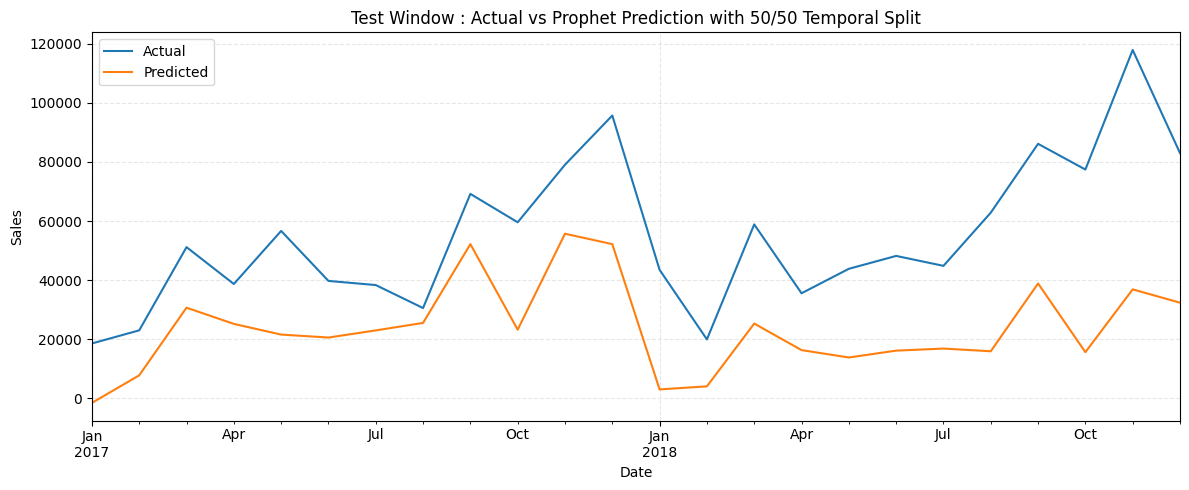

In [38]:
train_ppt = sales_ppt[sales_ppt["ds"].dt.year <= 2016]
test_ppt  = sales_ppt[sales_ppt["ds"].dt.year >= 2017]

train_ppt = train_ppt.sort_values("ds")
test_ppt = test_ppt.sort_values("ds")

model_ppt = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,  
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.09)

model_ppt.fit(train_ppt)
future_ppt = model_ppt.make_future_dataframe(periods=len(test_ppt), freq="M", include_history=True)
fcst_ppt = model_ppt.predict(future_ppt)

pred_ppt = (fcst_ppt.set_index("ds").loc[test_ppt["ds"], "yhat"].rename("yhat"))

## Evaludation ##

mask = test_ppt["y"] != 0 
actuals = test_ppt.loc[mask, "y"].values
preds = pred_ppt.loc[test_ppt.loc[mask, "ds"]].values

mae_ppt  = mean_absolute_error(actuals, preds)
rmse_ppt = np.sqrt(((actuals - preds) ** 2).mean())
mape_ppt = np.mean(np.abs((actuals - preds) / actuals)) * 100
mpe_ppt = np.mean((actuals - preds) / actuals) * 100

print(f"=== Baseline Prophet Results Based on Year-Based 50/50 Split ===")
print(f"MAE : {mae_ppt:,.2f}")
print(f"RMSE: {rmse_ppt:,.2f}")
print(f"MAPE: {mape_ppt:,.2f}%")
print(f"MPE: {mpe_ppt:,.2f}%")

## Plot ##
ax = test_ppt.set_index("ds")["y"].plot(figsize=(12,5), label="Actual")
pred_ppt.plot(ax=ax, label="Predicted")
plt.title("Test Window : Actual vs Prophet Prediction with 50/50 Temporal Split")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend(); plt.tight_layout(); plt.grid(True, linestyle="--", alpha=0.3); plt.show()

#################################################
### Prophet Feature Engineering with 80/20 split ###
#################################################

20:18:58 - cmdstanpy - INFO - Chain [1] start processing
20:18:58 - cmdstanpy - INFO - Chain [1] done processing


=== Final Prophet Reults with Enforced Features ===
MAE : 10,840.32
RMSE: 13,166.62
MAPE: 16.50%
MPE: 2.39%


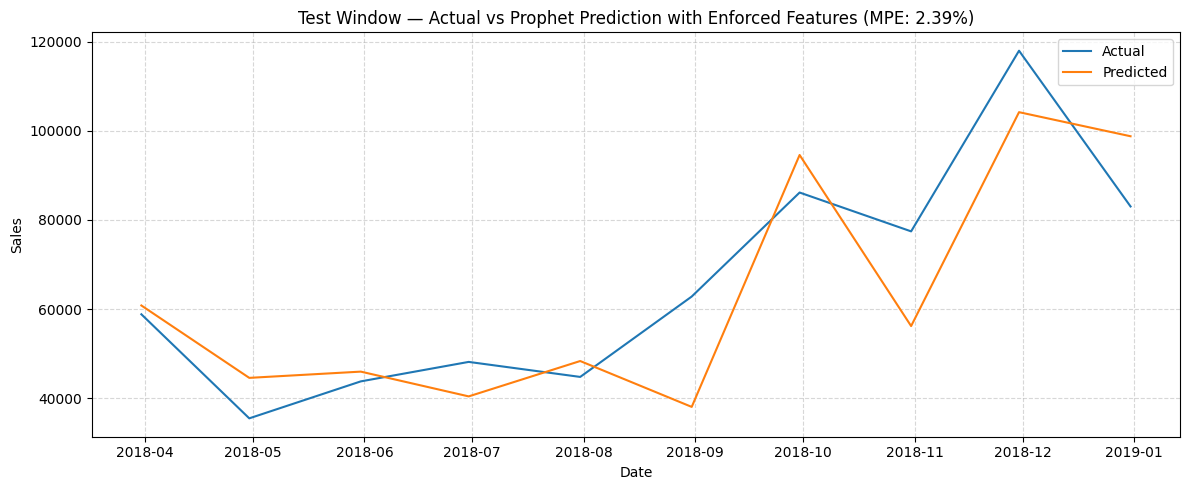

In [39]:
########################
## Enforcing features ##
########################
sales_ppt = sales_ppt.copy()
sales_ppt["month"] = sales_ppt["ds"].dt.month
sales_ppt["year"] = sales_ppt["ds"].dt.year

# Monthly regressors
sales_ppt["is_black_friday"] = (sales_ppt["month"] == 11).astype(int)       
sales_ppt["is_september"] = (sales_ppt["month"] == 9).astype(int)
sales_ppt["is_november"] = (sales_ppt["month"] == 11).astype(int)
sales_ppt["is_december"] = (sales_ppt["month"] == 12).astype(int)
sales_ppt["is_january"] = (sales_ppt["month"] == 1).astype(int)         


#################
## 80/20 split ##
#################
split_point = int(len(sales_ppt)*0.8)
train_ppt = sales_ppt.iloc[:split_point]
test_ppt = sales_ppt.iloc[split_point:]

freq = pd.infer_freq(sales_ppt["ds"])
if freq is None:
    freq = "M" ##frequency taken at monthly


model_ppt = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,  
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.09)

model_ppt.add_seasonality(
    name="quarterly",
    period=91.25, #365.25/4
    fourier_order=2) #conrtroling how complex the seasonl pattern is allowed to be.


## adding holiday regressor ##
model_ppt.add_regressor("is_black_friday", mode="multiplicative")
model_ppt.add_regressor("is_september", mode="multiplicative")
model_ppt.add_regressor("is_november", mode="multiplicative")
model_ppt.add_regressor("is_december", mode="multiplicative")
model_ppt.add_regressor("is_january", mode="additive")

model_ppt.add_country_holidays(country_name='US') #adding holiday doesnt make much difference when working with monthly aggregate

model_ppt.fit(train_ppt[["ds", "y","is_black_friday", "is_september","is_november","is_december", "is_january"]])
future = model_ppt.make_future_dataframe(periods=len(test_ppt), freq=freq, include_history=False)

########################
## Enforcing features ##
########################
future["month"] = future["ds"].dt.month
future["is_black_friday"] = (future["month"] == 11).astype(int)
future["is_september"] = (future["month"] == 9).astype(int)
future["is_november"] = (future["month"] == 11).astype(int)
future["is_december"] = (future["month"] == 12).astype(int)
future["is_january"] = (future["month"] == 1).astype(int)

future = future[["ds","is_black_friday", "is_september","is_november","is_december", "is_january"]]
fcst = model_ppt.predict(future)
pred_ppt = (fcst.set_index("ds").loc[test_ppt["ds"], "yhat"].rename("yhat"))

################
## Evaluation ##
################

mask = test_ppt["y"] != 0 
actuals = test_ppt.loc[mask, "y"].values
preds = pred_ppt.loc[test_ppt.loc[mask, "ds"]].values

mae_ppt  = mean_absolute_error(actuals, preds)
rmse_ppt = np.sqrt(((actuals - preds) ** 2).mean())
mape_ppt = np.mean(np.abs((actuals - preds) / actuals)) * 100
mpe_ppt = np.mean((actuals - preds) / actuals) * 100
print(f"=== Final Prophet Reults with Enforced Features ===")
print(f"MAE : {mae_ppt:,.2f}")
print(f"RMSE: {rmse_ppt:,.2f}")
print(f"MAPE: {mape_ppt:,.2f}%")
print(f"MPE: {mpe_ppt:,.2f}%")

################
## Final Plot ##
################

test_dates = pd.to_datetime(test_ppt["ds"])
actual_plot = pd.Series(test_ppt["y"].values, index=test_dates, name="Actual")
pred_plot = pd.Series(pred_ppt.values, index=test_dates, name="Predicted")

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(actual_plot.index, actual_plot.values, label="Actual")
ax.plot(pred_plot.index, pred_plot.values, label="Predicted")
ax.set_title("Test Window — Actual vs Prophet Prediction with Enforced Features (MPE: 2.39%)")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.legend()
plt.xticks(); plt.tight_layout(); plt.grid(True, linestyle="--", alpha=0.5); plt.show()

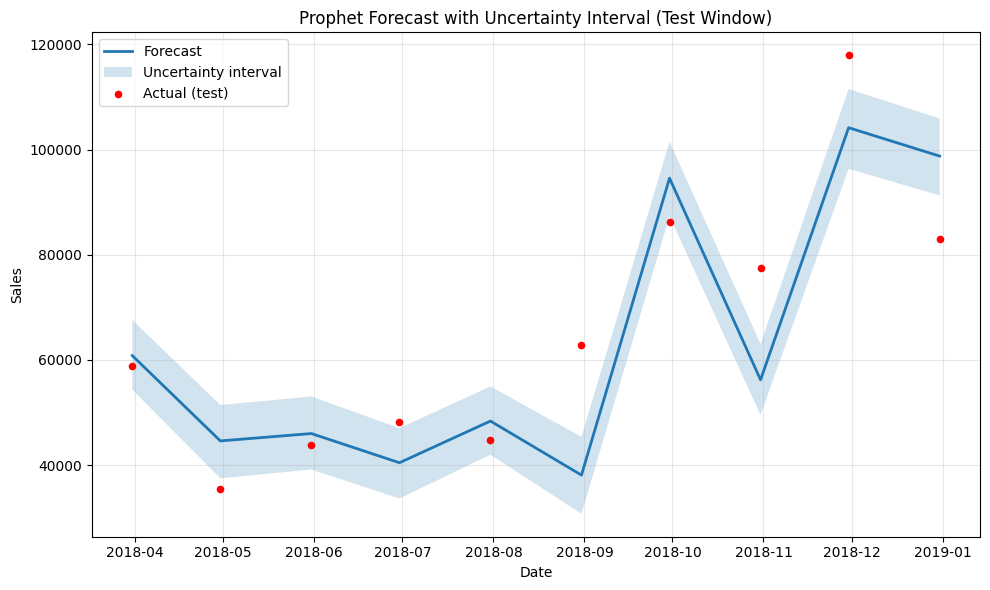

In [40]:
## Plotting Prophet with uncertainty interval 
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(fcst["ds"], fcst["yhat"], label="Forecast", linewidth=2)

# Uncertainty interval
ax.fill_between(fcst["ds"], fcst["yhat_lower"], fcst["yhat_upper"], alpha=0.2,label="Uncertainty interval")

# Actual test points
ax.scatter(test_ppt["ds"], test_ppt["y"], color="r", s=20, label="Actual (test)", zorder=3)

ax.set_title("Prophet Forecast with Uncertainty Interval (Test Window)")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend(); ax.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

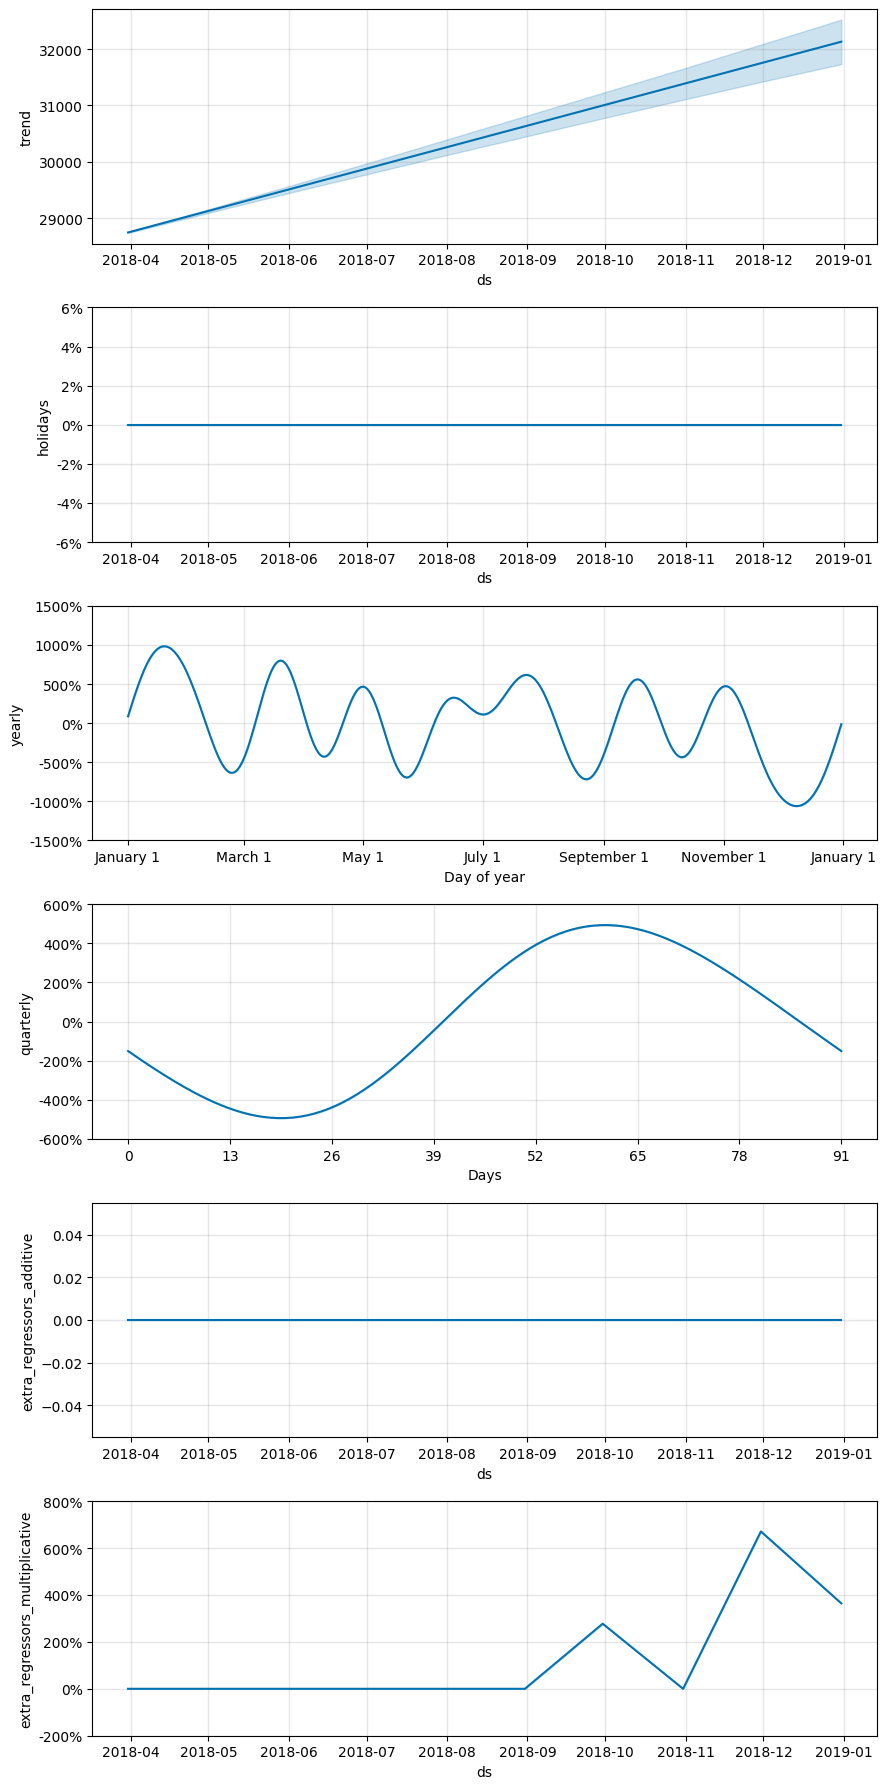

In [41]:
fig = model_ppt.plot_components(fcst)

## XGBoost

###############################
### Random Split - XGB Baseline ##
###############################

=== Baseline XGBoost Results Based on Random Split ===
MAE: 12,624.19
RMSE: 13,943.10
MAPE: 25.60%
MPE: 17.36%


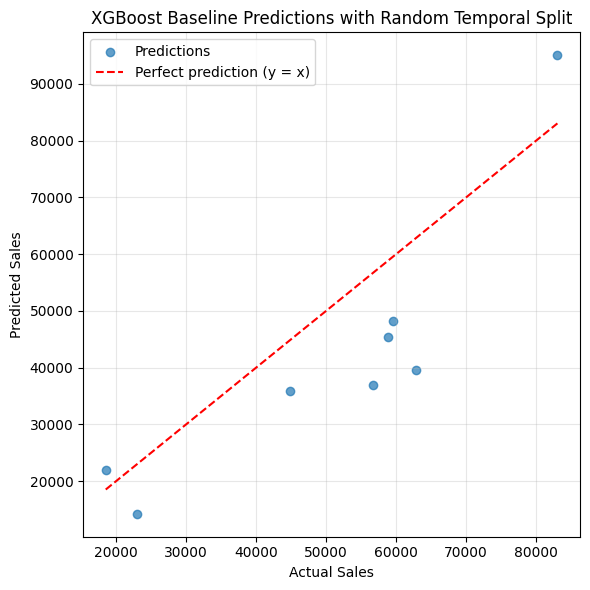

In [42]:
## Monthly Aggregate Sales for XGBoost all models 
sales_xgb = sales_ppt.copy().sort_values("ds").reset_index(drop=True)
sales_xgb["log_y"] = np.log1p(sales_xgb["y"]) #log transformation

sales_xgb["year"] = sales_xgb["ds"].dt.year
sales_xgb["month"] = sales_xgb["ds"].dt.month
sales_xgb["lag_1"] = sales_xgb["y"].shift(1)
sales_xgb["lag_12"] = sales_xgb["y"].shift(12)

sales_xgb = sales_xgb.dropna().reset_index(drop=True)

features = ["year","month",
            "lag_1",
            "lag_12"]

X = sales_xgb[features]
y = sales_xgb["log_y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=random_seed)

model_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01,
                         max_depth=5,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         random_state=random_seed)
model_xgb.fit(X_train, y_train)

log_pred_ran = model_xgb.predict(X_test)
y_pred_xgb_ran = np.expm1(log_pred_ran)  
y_true_xgb_ran = np.expm1(y_test)

## Evaluation ##

mae_xgb_ran = mean_absolute_error(y_true_xgb_ran, y_pred_xgb_ran)
rmse_xgb_ran = np.sqrt(mean_squared_error(y_true_xgb_ran, y_pred_xgb_ran))
mape_xgb_ran = np.mean(np.abs((y_true_xgb_ran - y_pred_xgb_ran) / y_true_xgb_ran)) * 100
mpe_xgb_ran = np.mean((y_true_xgb_ran - y_pred_xgb_ran) / y_true_xgb_ran) * 100
print(f"=== Baseline XGBoost Results Based on Random Split ===")
print(f"MAE: {mae_xgb_ran:,.2f}")
print(f"RMSE: {rmse_xgb_ran:,.2f}")
print(f"MAPE: {mape_xgb_ran:.2f}%")
print(f"MPE: {mpe_xgb_ran:.2f}%")

# Plot ##

plt.figure(figsize=(6,6))
plt.scatter(y_true_xgb_ran, y_pred_xgb_ran, alpha=0.7,label="Predictions")

plt.plot([y_true_xgb_ran.min(), y_true_xgb_ran.max()],
         [y_true_xgb_ran.min(), y_true_xgb_ran.max()],"r--",label="Perfect prediction (y = x)")

plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("XGBoost Baseline Predictions with Random Temporal Split")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

#####################################
### Row-based 80/20 - XGB baseline ###
#####################################

=== Baseline XGBoost Results Based on Row-Based 80/20 ===
MAE: 15,571.55
RMSE: 18,223.96
MAPE: 22.08%
MPE: 18.11%


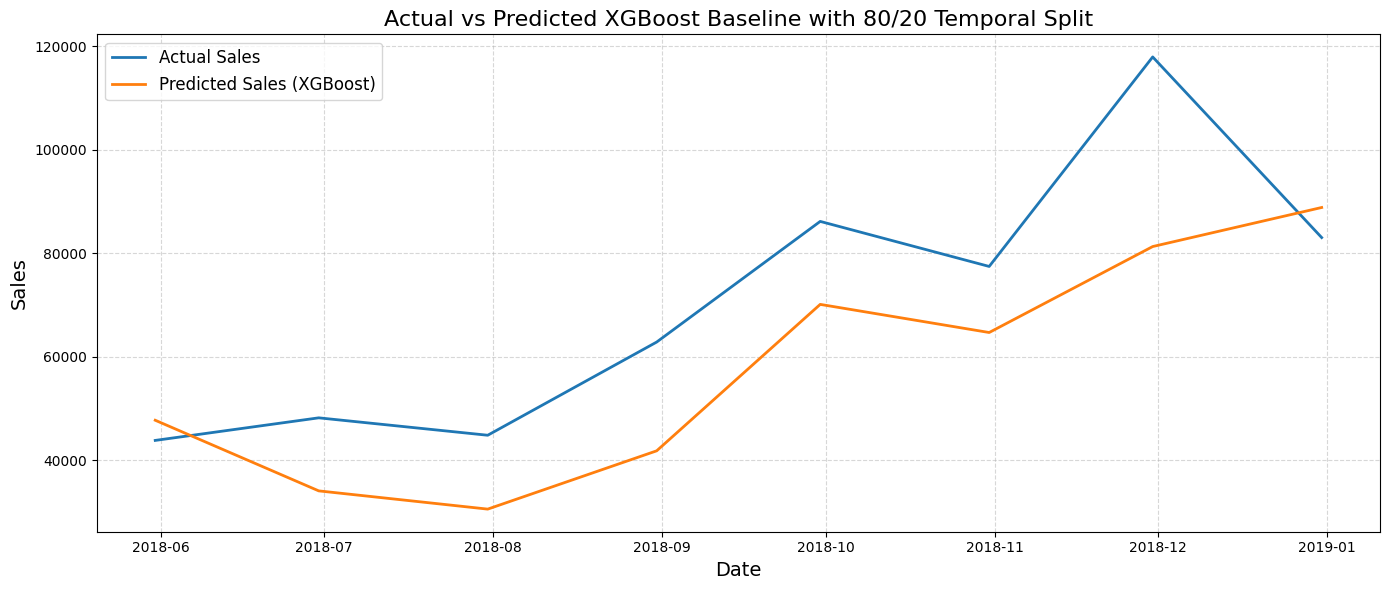

In [43]:
sales_xgb = sales_ppt.copy().sort_values("ds").reset_index(drop=True)
# sales_xgb = sales_xgb.copy()
sales_xgb["log_y"] = np.log1p(sales_xgb["y"]) #log transformation

sales_xgb["year"] = sales_xgb["ds"].dt.year
sales_xgb["month"] = sales_xgb["ds"].dt.month
sales_xgb["lag_1"] = sales_xgb["y"].shift(1)
sales_xgb["lag_12"] = sales_xgb["y"].shift(12)

sales_xgb = sales_xgb.dropna().reset_index(drop=True)

split = int(len(sales_xgb) * 0.8)
train_xgb = sales_xgb.iloc[:split]
test_xgb = sales_xgb.iloc[split:]

features = ["year","month",
            "lag_1",
            "lag_12"]

X_train = train_xgb[features]
y_train = train_xgb["log_y"]

X_test = test_xgb[features]
y_test = test_xgb["log_y"]

model_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01,
                         max_depth=5,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         random_state=random_seed)
model_xgb.fit(X_train, y_train)

log_pred = model_xgb.predict(X_test)
y_pred_xgb = np.expm1(log_pred)  
y_true_xgb = np.expm1(y_test)

## Evaluation ##

mae_xgb = mean_absolute_error(y_true_xgb, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_true_xgb, y_pred_xgb))
mape_xgb = np.mean(np.abs((y_true_xgb - y_pred_xgb) / y_true_xgb)) * 100
mpe_xgb = np.mean((y_true_xgb - y_pred_xgb) / y_true_xgb) * 100
print(f"=== Baseline XGBoost Results Based on Row-Based 80/20 ===")
print(f"MAE: {mae_xgb:,.2f}")
print(f"RMSE: {rmse_xgb:,.2f}")
print(f"MAPE: {mape_xgb:.2f}%")
print(f"MPE: {mpe_xgb:.2f}%")

## Plot ##
plt.figure(figsize=(14,6))
plt.plot(test_xgb["ds"], y_true_xgb, label="Actual Sales", linewidth=2)
plt.plot(test_xgb["ds"], y_pred_xgb, label="Predicted Sales (XGBoost)", linewidth=2)
plt.title("Actual vs Predicted XGBoost Baseline with 80/20 Temporal Split", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Sales", fontsize=14)
plt.legend(fontsize=12); plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout();plt.show()

#####################################
### Year-based 75/25 - XGB baseline ###
#####################################

=== Baseline XGBoost Results Based on Year-Based 75/25 ===
MAE: 15,222.09
RMSE: 18,337.07
MAPE: 24.23%
MPE: 20.51%


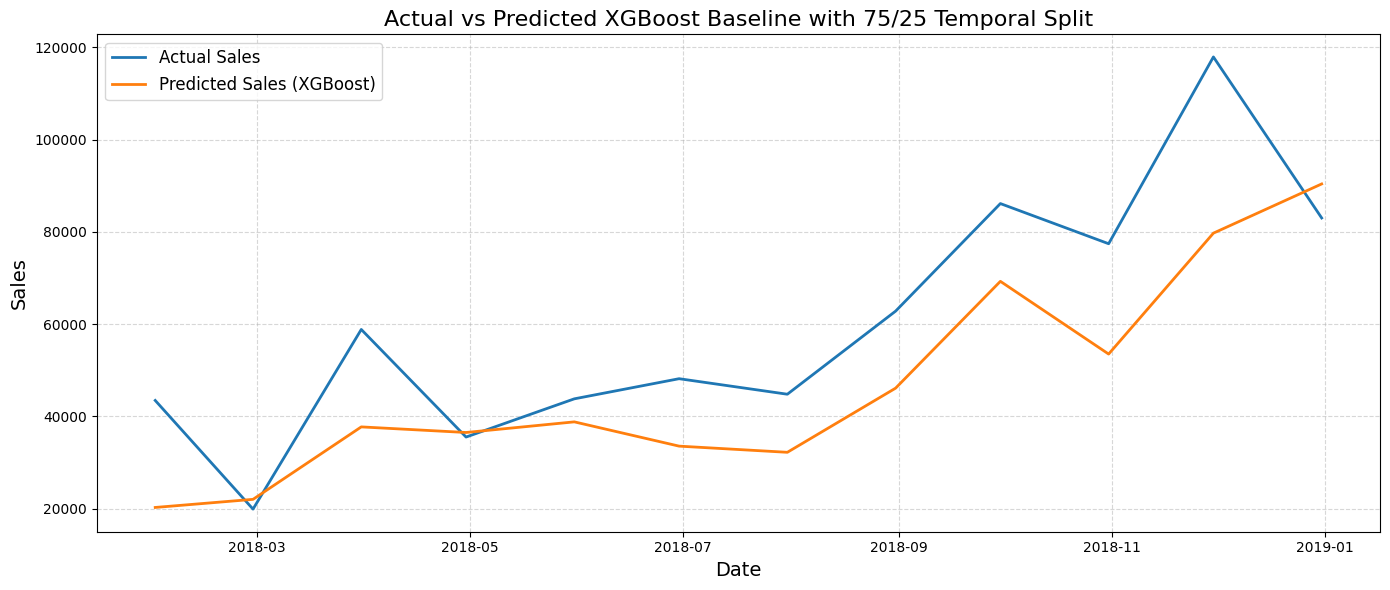

In [44]:
sales_xgb = sales_ppt.copy().sort_values("ds").reset_index(drop=True)
sales_xgb["log_y"] = np.log1p(sales_xgb["y"]) #log transformation

sales_xgb["year"] = sales_xgb["ds"].dt.year
sales_xgb["month"] = sales_xgb["ds"].dt.month
sales_xgb["lag_1"] = sales_xgb["y"].shift(1)
sales_xgb["lag_12"] = sales_xgb["y"].shift(12)

sales_xgb = sales_xgb.dropna().reset_index(drop=True)

train_xgb = sales_xgb[sales_xgb["year"] <= 2017]
test_xgb  = sales_xgb[sales_xgb["year"] == 2018]

features = ["year","month",
            "lag_1",
            "lag_12"]

X_train = train_xgb[features]
y_train = train_xgb["log_y"]

X_test = test_xgb[features]
y_test = test_xgb["log_y"]

model_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01,
                         max_depth=5,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         random_state=random_seed)
model_xgb.fit(X_train, y_train)

log_pred = model_xgb.predict(X_test)
y_pred_xgb = np.expm1(log_pred)  
y_true_xgb = np.expm1(y_test)

## Evaluation ##

mae_xgb = mean_absolute_error(y_true_xgb, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_true_xgb, y_pred_xgb))
mape_xgb = np.mean(np.abs((y_true_xgb - y_pred_xgb) / y_true_xgb)) * 100
mpe_xgb = np.mean((y_true_xgb - y_pred_xgb) / y_true_xgb) * 100
print(f"=== Baseline XGBoost Results Based on Year-Based 75/25 ===")
print(f"MAE: {mae_xgb:,.2f}")
print(f"RMSE: {rmse_xgb:,.2f}")
print(f"MAPE: {mape_xgb:.2f}%")
print(f"MPE: {mpe_xgb:.2f}%")

## Plot ##

plt.figure(figsize=(14,6))
plt.plot(test_xgb["ds"], y_true_xgb, label="Actual Sales", linewidth=2)
plt.plot(test_xgb["ds"], y_pred_xgb, label="Predicted Sales (XGBoost)", linewidth=2)
plt.title("Actual vs Predicted XGBoost Baseline with 75/25 Temporal Split", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Sales", fontsize=14)
plt.legend(fontsize=12);plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()

#####################################
### Year-based 50/50 - XGB baseline ###
#####################################

=== Baseline XGBoost Results Based on Year-Based 50/50 ===
MAE: 18,316.00
RMSE: 21,820.77
MAPE: 32.28%
MPE: 32.14%


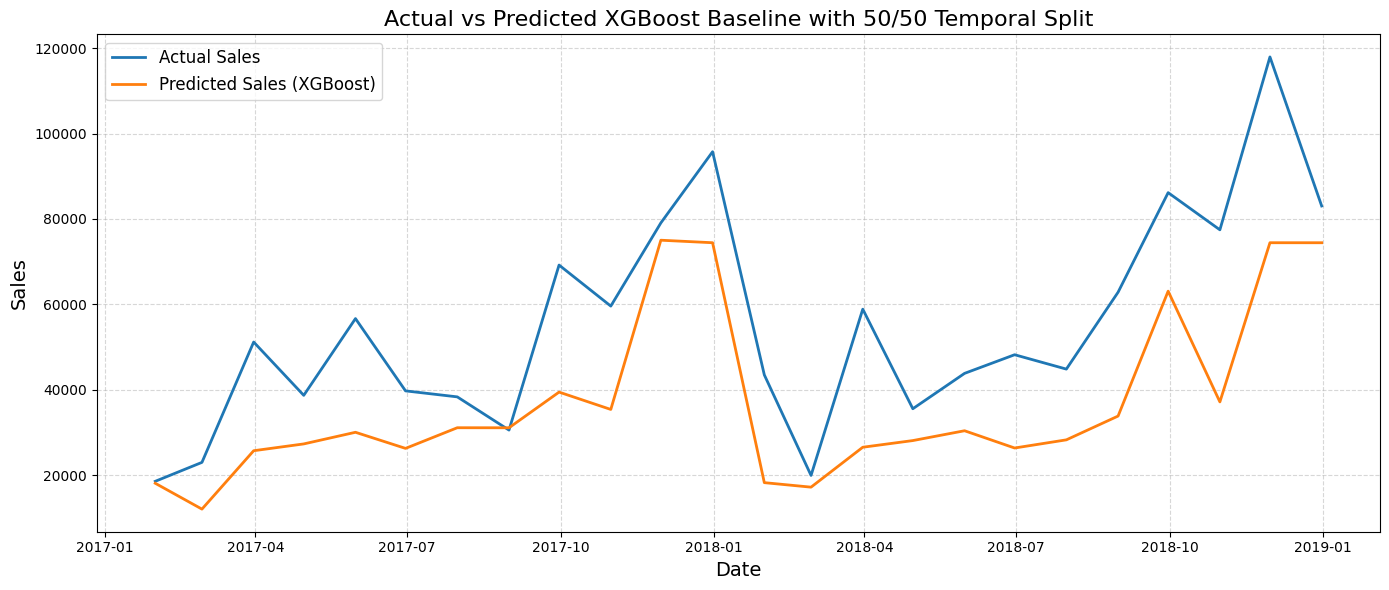

In [45]:
sales_xgb = sales_ppt.copy().sort_values("ds").reset_index(drop=True)
sales_xgb["log_y"] = np.log1p(sales_xgb["y"]) #log transformation

sales_xgb["year"] = sales_xgb["ds"].dt.year
sales_xgb["month"] = sales_xgb["ds"].dt.month
sales_xgb["lag_1"] = sales_xgb["y"].shift(1)
sales_xgb["lag_12"] = sales_xgb["y"].shift(12)

sales_xgb = sales_xgb.dropna().reset_index(drop=True)

train_xgb = sales_xgb[sales_xgb["year"] <= 2016]
test_xgb  = sales_xgb[sales_xgb["year"] >= 2017]

features = ["year","month",
            "lag_1",
            "lag_12"]

X_train = train_xgb[features]
y_train = train_xgb["log_y"]

X_test = test_xgb[features]
y_test = test_xgb["log_y"]

model_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01,
                         max_depth=5,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         random_state=random_seed)
model_xgb.fit(X_train, y_train)

log_pred = model_xgb.predict(X_test)
y_pred = np.expm1(log_pred)  
y_true = np.expm1(y_test)

## Evaludation ##

mae_xgb = mean_absolute_error(y_true, y_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_true, y_pred))
mape_xgb = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mpe_xgb = np.mean((y_true - y_pred) / y_true) * 100
print(f"=== Baseline XGBoost Results Based on Year-Based 50/50 ===")
print(f"MAE: {mae_xgb:,.2f}")
print(f"RMSE: {rmse_xgb:,.2f}")
print(f"MAPE: {mape_xgb:.2f}%")
print(f"MPE: {mpe_xgb:.2f}%")

## Plot ##

plt.figure(figsize=(14,6))
plt.plot(test_xgb["ds"], y_true, label="Actual Sales", linewidth=2)
plt.plot(test_xgb["ds"], y_pred, label="Predicted Sales (XGBoost)", linewidth=2)
plt.title("Actual vs Predicted XGBoost Baseline with 50/50 Temporal Split", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Sales", fontsize=14)
plt.legend(fontsize=12); plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()

## XGB Baseline Test with HPO Methods: RS vs TPE

############################################
### XGB Baseline 80/20 - RS Optimisation ###
############################################

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params: {'subsample': 0.9, 'reg_lambda': 10, 'reg_alpha': 0.01, 'n_estimators': 300, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}
=== Baseline XGBoost Results with Random Search HPO (80/20 Split) ===
MAE : 16,703.86
RMSE: 18,931.23
MAPE: 24.42%
MPE: 15.64%


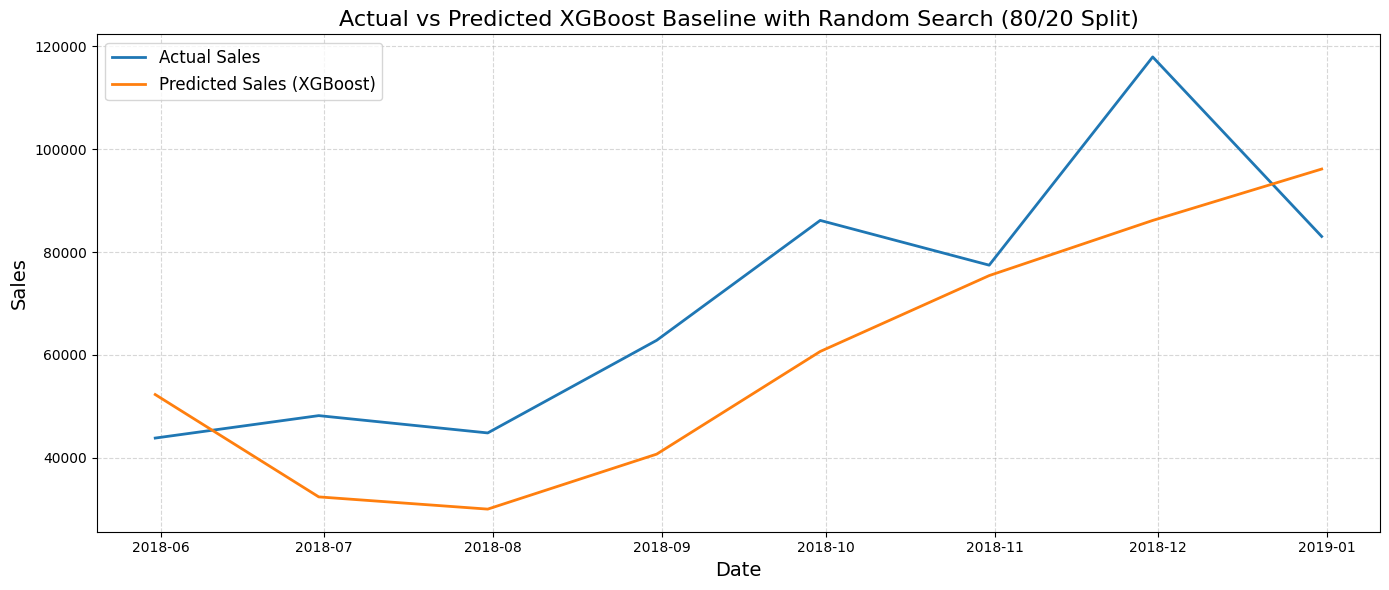

In [46]:
sales_xgb = sales_ppt.copy().sort_values("ds").reset_index(drop=True)
sales_xgb["log_y"] = np.log1p(sales_xgb["y"]) #log transformation

sales_xgb["year"] = sales_xgb["ds"].dt.year
sales_xgb["month"] = sales_xgb["ds"].dt.month
sales_xgb["lag_1"] = sales_xgb["y"].shift(1)
sales_xgb["lag_12"] = sales_xgb["y"].shift(12)

sales_xgb = sales_xgb.dropna().reset_index(drop=True)

split = int(len(sales_xgb) * 0.8)
train_xgb = sales_xgb.iloc[:split]
test_xgb = sales_xgb.iloc[split:]

features = ["year","month",
            "lag_1",
            "lag_12"]

X_train = train_xgb[features]
y_train = train_xgb["log_y"]

X_test = test_xgb[features]
y_test = test_xgb["log_y"]

tscv = TimeSeriesSplit(n_splits=3) #This ensures training folds always occur before validation folds, avoiding leakage.

param_grid = {"n_estimators": [300, 600, 1000, 1500],
              "learning_rate": [0.01, 0.03, 0.05, 0.1],
              "max_depth": [3, 4, 5, 6, 8],
              "min_child_weight": [1, 2, 5, 10],
              "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
              "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
              "gamma": [0, 0.01, 0.1, 0.5],
              "reg_alpha": [0, 0.01, 0.1, 1],
              "reg_lambda": [0.1, 1, 5, 10]}

xgb = XGBRegressor(objective="reg:squarederror", random_state=random_seed)

search = RandomizedSearchCV(estimator=xgb,
                            param_distributions=param_grid,
                            n_iter=30,
                            scoring="neg_mean_absolute_error",cv=tscv,
                            verbose=1,
                            random_state=random_seed,
                            n_jobs=-1)

search.fit(X_train, y_train)

best_model = search.best_estimator_
print("Best params:", search.best_params_)

log_pred = best_model.predict(X_test)
y_pred = np.expm1(log_pred)    
y_true = np.expm1(y_test)

## Evaluation ##

mae_xgb = mean_absolute_error(y_true, y_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_true, y_pred))
mape_xgb = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mpe_xgb = np.mean((y_true - y_pred) / y_true) * 100
print(f"=== Baseline XGBoost Results with Random Search HPO (80/20 Split) ===")
print(f"MAE : {mae_xgb:,.2f}")
print(f"RMSE: {rmse_xgb:,.2f}")
print(f"MAPE: {mape_xgb:.2f}%")
print(f"MPE: {mpe_xgb:.2f}%")

## Plot ##
plt.figure(figsize=(14,6))
plt.plot(test_xgb["ds"], y_true, label="Actual Sales", linewidth=2)
plt.plot(test_xgb["ds"], y_pred, label="Predicted Sales (XGBoost)", linewidth=2)
plt.title("Actual vs Predicted XGBoost Baseline with Random Search (80/20 Split)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Sales", fontsize=14)
plt.legend(fontsize=12); plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()

############################################
### XGB Baseline 75/25 - RS Optimisation ###
############################################

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 600, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
=== Baseline XGBoost Results with Random Search HPO (75/25 Split) ===
MAE : 13,972.83
RMSE: 18,022.52
MAPE: 21.25%
MPE: 17.59%


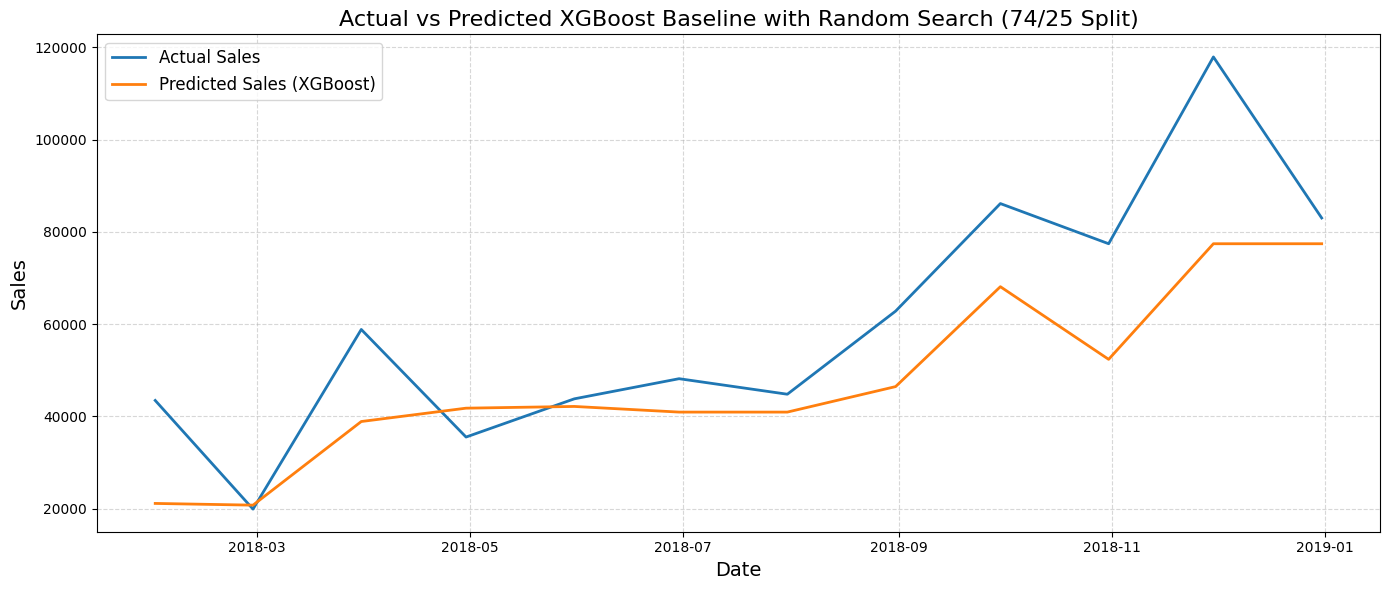

In [47]:
sales_xgb = sales_ppt.copy().sort_values("ds").reset_index(drop=True)
sales_xgb["log_y"] = np.log1p(sales_xgb["y"]) #log transformation

sales_xgb["year"] = sales_xgb["ds"].dt.year
sales_xgb["month"] = sales_xgb["ds"].dt.month
sales_xgb["lag_1"] = sales_xgb["y"].shift(1)
sales_xgb["lag_12"] = sales_xgb["y"].shift(12)

sales_xgb = sales_xgb.dropna().reset_index(drop=True)

train_xgb = sales_xgb[sales_xgb["year"] <= 2017]
test_xgb  = sales_xgb[sales_xgb["year"] == 2018]

features = ["year","month",
            "lag_1",
            "lag_12"]

X_train = train_xgb[features]
y_train = train_xgb["log_y"]

X_test = test_xgb[features]
y_test = test_xgb["log_y"]

tscv = TimeSeriesSplit(n_splits=3)

param_grid = {"n_estimators": [300, 600, 1000, 1500],
              "learning_rate": [0.01, 0.03, 0.05, 0.1],
              "max_depth": [3, 4, 5, 6, 8],
              "min_child_weight": [1, 2, 5, 10],
              "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
              "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
              "gamma": [0, 0.01, 0.1, 0.5],
              "reg_alpha": [0, 0.01, 0.1, 1],
              "reg_lambda": [0.1, 1, 5, 10]}

xgb = XGBRegressor(objective="reg:squarederror", random_state=random_seed)

search = RandomizedSearchCV(estimator=xgb,
                            param_distributions=param_grid,
                            n_iter=30,
                            scoring="neg_mean_absolute_error",cv=tscv,
                            verbose=1,
                            random_state=random_seed,
                            n_jobs=-1)

search.fit(X_train, y_train)
best_model = search.best_estimator_
print("Best params:", search.best_params_)

log_pred = best_model.predict(X_test)
y_pred = np.expm1(log_pred) 
y_true = np.expm1(y_test)

## Evaluation ##

mae_xgb = mean_absolute_error(y_true, y_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_true, y_pred))
mape_xgb = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mpe_xgb = np.mean((y_true - y_pred) / y_true) * 100
print(f"=== Baseline XGBoost Results with Random Search HPO (75/25 Split) ===")
print(f"MAE : {mae_xgb:,.2f}")
print(f"RMSE: {rmse_xgb:,.2f}")
print(f"MAPE: {mape_xgb:.2f}%")
print(f"MPE: {mpe_xgb:.2f}%")

## Plot ##

plt.figure(figsize=(14,6))
plt.plot(test_xgb["ds"], y_true, label="Actual Sales", linewidth=2)
plt.plot(test_xgb["ds"], y_pred, label="Predicted Sales (XGBoost)", linewidth=2)
plt.title("Actual vs Predicted XGBoost Baseline with Random Search (74/25 Split)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Sales", fontsize=14)
plt.legend(fontsize=12); plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()

############################################
### XGB baseline 80/20 - TPE Optimisation ###
############################################

[I 2026-02-01 20:20:29,816] A new study created in memory with name: no-name-ee9354f2-dbc9-4b22-a0e2-1c30ee09d38a
[I 2026-02-01 20:20:30,010] Trial 0 finished with value: 0.39242020547216566 and parameters: {'n_estimators': 749, 'learning_rate': 0.08927180304353628, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.02904180608409973, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 6.051038616257768}. Best is trial 0 with value: 0.39242020547216566.
[I 2026-02-01 20:20:30,305] Trial 1 finished with value: 0.4718261177134829 and parameters: {'n_estimators': 1150, 'learning_rate': 0.010485387725194618, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'gamma': 0.09170225492671691, 'reg_alpha': 0.3042422429595377, 'reg_lambda': 5.295088673159155}. Best is trial 0 with value: 0.39242020547216566.
[I 2026-02-01 20:20:30,518] Trial 2 finished with value: 0.41889

Best trial: 23
Best value (MAE): 0.2824324015122291
Best params: {'n_estimators': 534, 'learning_rate': 0.03227036807188651, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9520671035514535, 'colsample_bytree': 0.9995473267033408, 'gamma': 0.0015796876124737, 'reg_alpha': 0.011505677204958265, 'reg_lambda': 1.2367532559776035}
=== Baseline XGBoost Results with TPE HPO (80/20 Split) ===
MAE : 15,181.84
RMSE: 16,116.90
MAPE: 22.69%
MPE: 15.93%


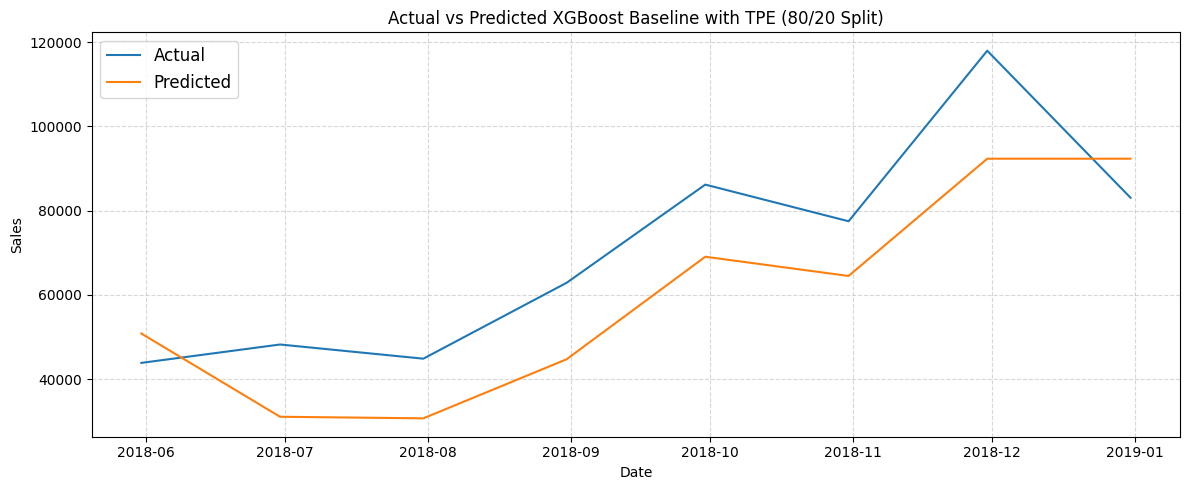

In [58]:
sales_xgb = sales_ppt.copy().sort_values("ds").reset_index(drop=True)
sales_xgb["log_y"] = np.log1p(sales_xgb["y"]) #log transformation

sales_xgb["year"] = sales_xgb["ds"].dt.year
sales_xgb["month"] = sales_xgb["ds"].dt.month
sales_xgb["lag_1"] = sales_xgb["y"].shift(1)
sales_xgb["lag_12"] = sales_xgb["y"].shift(12)

sales_daily_xgb = sales_xgb.dropna().reset_index(drop=True)

split = int(len(sales_daily_xgb) * 0.8)
train_xgb = sales_daily_xgb.iloc[:split]
test_xgb = sales_daily_xgb.iloc[split:]

features = ["year","month",
            "lag_1",
            "lag_12"]

X_train = train_xgb[features]
y_train = train_xgb["log_y"]

X_test = test_xgb[features]
y_test = test_xgb["log_y"]

def objective(trial):
    params = {"n_estimators": trial.suggest_int("n_estimators", 300, 1500),
              "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
              "max_depth": trial.suggest_int("max_depth", 3, 8),
              "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
              "subsample": trial.suggest_float("subsample", 0.6, 1.0),
              "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
              "gamma": trial.suggest_float("gamma", 0.0, 0.5),
              "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
              "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0),
              "random_state": random_seed,
              "objective": "reg:squarederror"}

    model_xgb = XGBRegressor(**params)

    split = int(len(X_train) * 0.8)
    X_tr, X_val = X_train.iloc[:split], X_train.iloc[split:]
    y_tr, y_val = y_train.iloc[:split], y_train.iloc[split:]

    y_tr = y_tr.values.ravel()
    y_val = y_val.values.ravel()
    
    model_xgb.fit(X_tr, y_tr)

    preds_xgb = model_xgb.predict(X_val)
    preds_xgb = np.array(preds_xgb).ravel()   # ensure 1D

    mae_xgb = mean_absolute_error(y_val, preds_xgb)
    return float(mae_xgb)

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50)   

print("Best trial:", study.best_trial.number)
print("Best value (MAE):", study.best_trial.value)
print("Best params:", study.best_trial.params)

best_params = study.best_trial.params
best_params["objective"] = "reg:squarederror"
best_params["random_state"] = random_seed

best_xgb_tpe = XGBRegressor(**best_params)
best_xgb_tpe.fit(X_train, y_train)

pred_log_xgb = best_xgb_tpe.predict(X_test)
pred_xgb = np.expm1(pred_log_xgb)       
actual_xgb = np.expm1(y_test)

## Evaluation ##

mae_xgb = mean_absolute_error(actual_xgb, pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(actual_xgb, pred_xgb))
mape_xgb = np.mean(np.abs((actual_xgb - pred_xgb) / actual_xgb)) * 100
mpe_xgb = np.mean((actual_xgb - pred_xgb) / actual_xgb) * 100
print(f"=== Baseline XGBoost Results with TPE HPO (80/20 Split) ===")
print(f"MAE : {mae_xgb:,.2f}")
print(f"RMSE: {rmse_xgb:,.2f}")
print(f"MAPE: {mape_xgb:.2f}%")
print(f"MPE: {mpe_xgb:.2f}%")

## Plot ##

plt.figure(figsize=(12,5))
plt.plot(test_xgb["ds"], actual_xgb, label="Actual")
plt.plot(test_xgb["ds"], pred_xgb, label="Predicted")
plt.title("Actual vs Predicted XGBoost Baseline with TPE (80/20 Split)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(fontsize=12); plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()

############################################
### XGB baseline 75/25 - TPE Optimisation ###
############################################

[I 2026-02-01 20:20:46,869] A new study created in memory with name: no-name-34a94199-da23-4bd2-8dca-1ce8c8d8af5e
[I 2026-02-01 20:20:47,066] Trial 0 finished with value: 0.485709392732138 and parameters: {'n_estimators': 749, 'learning_rate': 0.08927180304353628, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.02904180608409973, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 6.051038616257768}. Best is trial 0 with value: 0.485709392732138.
[I 2026-02-01 20:20:47,337] Trial 1 finished with value: 0.6648687478957122 and parameters: {'n_estimators': 1150, 'learning_rate': 0.010485387725194618, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'gamma': 0.09170225492671691, 'reg_alpha': 0.3042422429595377, 'reg_lambda': 5.295088673159155}. Best is trial 0 with value: 0.485709392732138.
[I 2026-02-01 20:20:47,548] Trial 2 finished with value: 0.53821049899

Best trial: 26
Best value (MAE): 0.2615726587233489
Best params: {'n_estimators': 924, 'learning_rate': 0.0236443701982983, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.762403617836841, 'colsample_bytree': 0.8230070606291231, 'gamma': 0.0011756078797717762, 'reg_alpha': 0.10045413985921203, 'reg_lambda': 1.4793191973637645}
=== Baseline XGBoost Results with TPE HPO (75/25 Split) ===
MAE : 13,971.76
RMSE: 16,787.54
MAPE: 22.33%
MPE: 19.10%


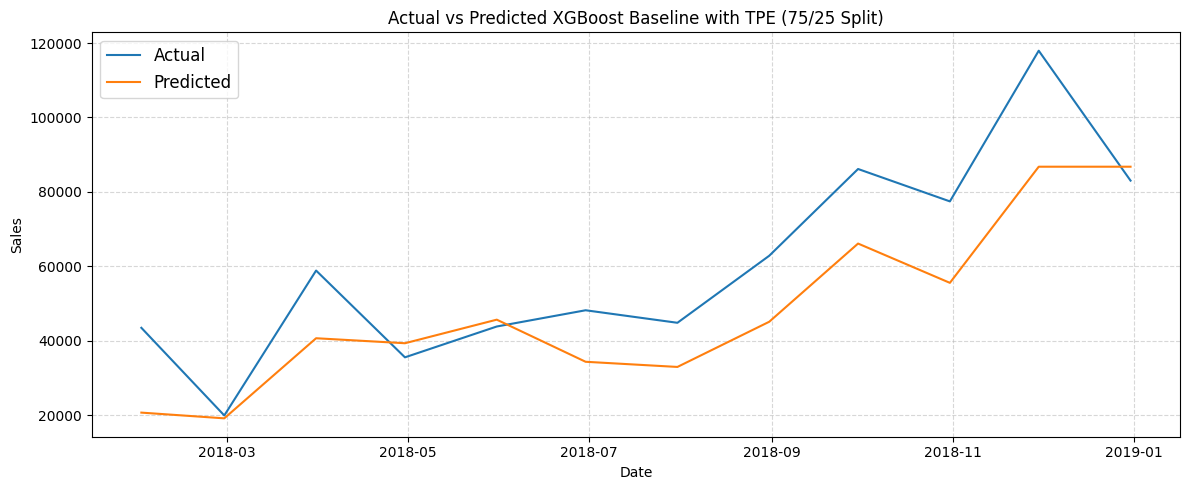

In [59]:
sales_xgb = sales_ppt.copy().sort_values("ds").reset_index(drop=True)
sales_xgb["log_y"] = np.log1p(sales_xgb["y"]) #log transformation

sales_xgb["year"] = sales_xgb["ds"].dt.year
sales_xgb["month"] = sales_xgb["ds"].dt.month
sales_xgb["lag_1"] = sales_xgb["y"].shift(1)
sales_xgb["lag_12"] = sales_xgb["y"].shift(12)

sales_daily_xgb = sales_xgb.dropna().reset_index(drop=True)

train_xgb = sales_daily_xgb[sales_daily_xgb["year"] <= 2017]
test_xgb  = sales_daily_xgb[sales_daily_xgb["year"] == 2018]

features = ["year","month",
            "lag_1",
            "lag_12"]

X_train = train_xgb[features]
y_train = train_xgb["log_y"]

X_test = test_xgb[features]
y_test = test_xgb["log_y"]

def objective(trial):
    params = {"n_estimators": trial.suggest_int("n_estimators", 300, 1500),
              "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
              "max_depth": trial.suggest_int("max_depth", 3, 8),
              "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
              "subsample": trial.suggest_float("subsample", 0.6, 1.0),
              "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
              "gamma": trial.suggest_float("gamma", 0.0, 0.5),
              "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
              "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0),
              "random_state": random_seed,
              "objective": "reg:squarederror"}

    model_xgb = XGBRegressor(**params)

    split = int(len(X_train) * 0.8)
    X_tr, X_val = X_train.iloc[:split], X_train.iloc[split:]
    y_tr, y_val = y_train.iloc[:split], y_train.iloc[split:]

    y_tr = y_tr.values.ravel()
    y_val = y_val.values.ravel()
    
    model_xgb.fit(X_tr, y_tr)

    preds_xgb = model_xgb.predict(X_val)
    preds_xgb = np.array(preds_xgb).ravel()   # ensure 1D

    mae_xgb = mean_absolute_error(y_val, preds_xgb)
    return float(mae_xgb)

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50)   

print("Best trial:", study.best_trial.number)
print("Best value (MAE):", study.best_trial.value)
print("Best params:", study.best_trial.params)

best_params = study.best_trial.params
best_params["objective"] = "reg:squarederror"
best_params["random_state"] = random_seed

best_xgb_tpe = XGBRegressor(**best_params)
best_xgb_tpe.fit(X_train, y_train)

pred_log_xgb = best_xgb_tpe.predict(X_test)
pred_xgb = np.expm1(pred_log_xgb)       
actual_xgb = np.expm1(y_test)

## Evaluation ##

mae_xgb = mean_absolute_error(actual_xgb, pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(actual_xgb, pred_xgb))
mape_xgb = np.mean(np.abs((actual_xgb - pred_xgb) / actual_xgb)) * 100
mpe_xgb = np.mean((actual_xgb - pred_xgb) / actual_xgb) * 100
print(f"=== Baseline XGBoost Results with TPE HPO (75/25 Split) ===")
print(f"MAE : {mae_xgb:,.2f}")
print(f"RMSE: {rmse_xgb:,.2f}")
print(f"MAPE: {mape_xgb:.2f}%")
print(f"MPE: {mpe_xgb:.2f}%")

## Plot ##

plt.figure(figsize=(12,5))
plt.plot(test_xgb["ds"], actual_xgb, label="Actual")
plt.plot(test_xgb["ds"], pred_xgb, label="Predicted")
plt.title("Actual vs Predicted XGBoost Baseline with TPE (75/25 Split)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(fontsize=12); plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()

## XGBOOST Final Model Feature Engineering: TPE vs RS

## XGB 80/20 TPE Feature Engineering #

[I 2026-02-01 20:21:04,815] A new study created in memory with name: no-name-378fcea3-ca41-4d50-b7aa-927f7fffbe60
[I 2026-02-01 20:21:05,022] Trial 0 finished with value: 0.3699250946424944 and parameters: {'n_estimators': 749, 'learning_rate': 0.08927180304353628, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.02904180608409973, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 6.051038616257768}. Best is trial 0 with value: 0.3699250946424944.
[I 2026-02-01 20:21:05,329] Trial 1 finished with value: 0.46632325796209945 and parameters: {'n_estimators': 1150, 'learning_rate': 0.010485387725194618, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'gamma': 0.09170225492671691, 'reg_alpha': 0.3042422429595377, 'reg_lambda': 5.295088673159155}. Best is trial 0 with value: 0.3699250946424944.
[I 2026-02-01 20:21:05,549] Trial 2 finished with value: 0.4212377

Best trial: 17
Best value (MAE): 0.29012464781428804
Best params: {'n_estimators': 1242, 'learning_rate': 0.031251394450237176, 'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.8587932824724065, 'colsample_bytree': 0.6682570583344382, 'gamma': 0.04105245223196716, 'reg_alpha': 0.03630481323211837, 'reg_lambda': 0.41551798490728664}
=== Final XGBoost Results with TPE HPO (80/20 Split) ===
MAE : 12,516.39
RMSE: 16,562.27
MAPE: 17.66%
MPE: 3.24%
RMSLE: 0.24%


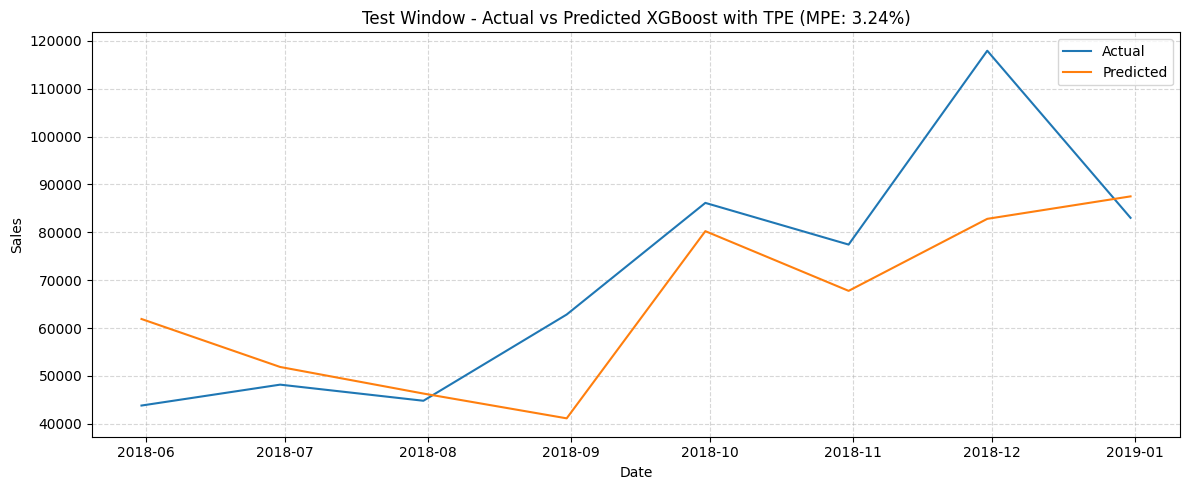

In [60]:
sales_xgb = sales_ppt.copy().sort_values("ds").reset_index(drop=True)
sales_xgb["log_y"] = np.log1p(sales_xgb["y"]) #log transformation

sales_xgb["year"] = sales_xgb["ds"].dt.year
sales_xgb["month"] = sales_xgb["ds"].dt.month
sales_xgb["quarter"] = sales_xgb["ds"].dt.quarter

sales_xgb["lag_1"] = sales_xgb["y"].shift(1)
sales_xgb["lag_3"] = sales_xgb["y"].shift(3)
sales_xgb["lag_6"] = sales_xgb["y"].shift(6)
sales_xgb["lag_12"] = sales_xgb["y"].shift(12)


sales_xgb["roll_mean_12"] = sales_xgb["y"].shift(1).rolling(12).mean()
sales_xgb["roll_std_6"] = sales_xgb["y"].shift(1).rolling(6).std()

sales_xgb["is_month_start"] = sales_xgb["ds"].dt.is_month_start.astype(int)
sales_xgb["is_month_end"] = sales_xgb["ds"].dt.is_month_end.astype(int)

sales_xgb = sales_xgb.dropna().reset_index(drop=True)

split = int(len(sales_xgb) * 0.8)
train_xgb = sales_xgb.iloc[:split]
test_xgb = sales_xgb.iloc[split:]

features = [
    "year","month",
    "quarter",
    "lag_1",
    # "lag_2",
    "lag_3","lag_6",
    "lag_12",
    # "roll_mean_1",
    # "roll_mean_3",
    # "roll_mean_6",
    "roll_mean_12",
    # "roll_std_3",
    "roll_std_6",
    # "roll_std_12",
    "is_month_start", "is_month_end",
    # "month_sin", "month_cos",
    # "is_september",
    # "is_november",
    # "is_december",
    # "is_black_friday",
    # "is_holiday"
]

X_train = train_xgb[features]
y_train = train_xgb["log_y"]

X_test = test_xgb[features]
y_test = test_xgb["log_y"]

def objective(trial):
    params = {"n_estimators": trial.suggest_int("n_estimators", 300, 1500),
              "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
              "max_depth": trial.suggest_int("max_depth", 3, 8),
              "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
              "subsample": trial.suggest_float("subsample", 0.6, 1.0),
              "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
              "gamma": trial.suggest_float("gamma", 0.0, 0.5),
              "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
              "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0),
              "random_state": random_seed,
              "objective": "reg:squarederror"}

    model_xgb = XGBRegressor(**params)

    # Single hold-out validation split
    split = int(len(X_train) * 0.8)
    X_tr, X_val = X_train.iloc[:split], X_train.iloc[split:]
    y_tr, y_val = y_train.iloc[:split], y_train.iloc[split:]

    y_tr = y_tr.values.ravel()
    y_val = y_val.values.ravel()
    
    model_xgb.fit(X_tr, y_tr)

    preds_xgb = model_xgb.predict(X_val)
    preds_xgb = np.array(preds_xgb).ravel()  

    mae_xgb = mean_absolute_error(y_val, preds_xgb)
    return float(mae_xgb)

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50)   

print("Best trial:", study.best_trial.number)
print("Best value (MAE):", study.best_trial.value)
print("Best params:", study.best_trial.params)

best_params = study.best_trial.params
best_params["objective"] = "reg:squarederror"
best_params["random_state"] = random_seed

best_xgb_tpe = XGBRegressor(**best_params)
best_xgb_tpe.fit(X_train, y_train)

pred_log_xgb = best_xgb_tpe.predict(X_test)
pred_xgb = np.expm1(pred_log_xgb)      
actual_xgb = np.expm1(y_test)

## Evaluation ##

mae_xgb = mean_absolute_error(actual_xgb, pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(actual_xgb, pred_xgb))
mape_xgb = np.mean(np.abs((actual_xgb - pred_xgb) / actual_xgb)) * 100
mpe_xgb = np.mean((actual_xgb - pred_xgb) / actual_xgb) * 100
rmsle_xgb = np.sqrt(mean_squared_log_error(actual_xgb, pred_xgb))
print(f"=== Final XGBoost Results with TPE HPO (80/20 Split) ===")
print(f"MAE : {mae_xgb:,.2f}")
print(f"RMSE: {rmse_xgb:,.2f}")
print(f"MAPE: {mape_xgb:.2f}%")
print(f"MPE: {mpe_xgb:.2f}%")
print(f"RMSLE: {rmsle_xgb:.2f}%")

## Plot ##
plt.figure(figsize=(12,5))
plt.plot(test_xgb["ds"], actual_xgb, label="Actual")
plt.plot(test_xgb["ds"], pred_xgb, label="Predicted")
plt.title("Test Window - Actual vs Predicted XGBoost with TPE (MPE: 3.24%)")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend(); plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()

## XGB 80/20 RS Feature Engineering #

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 600, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}
=== Final XGBoost Results with RS HPO (80/20 Split) ===
MAE : 11,826.15
RMSE: 14,219.49
MAPE: 17.74%
MPE: 6.96%


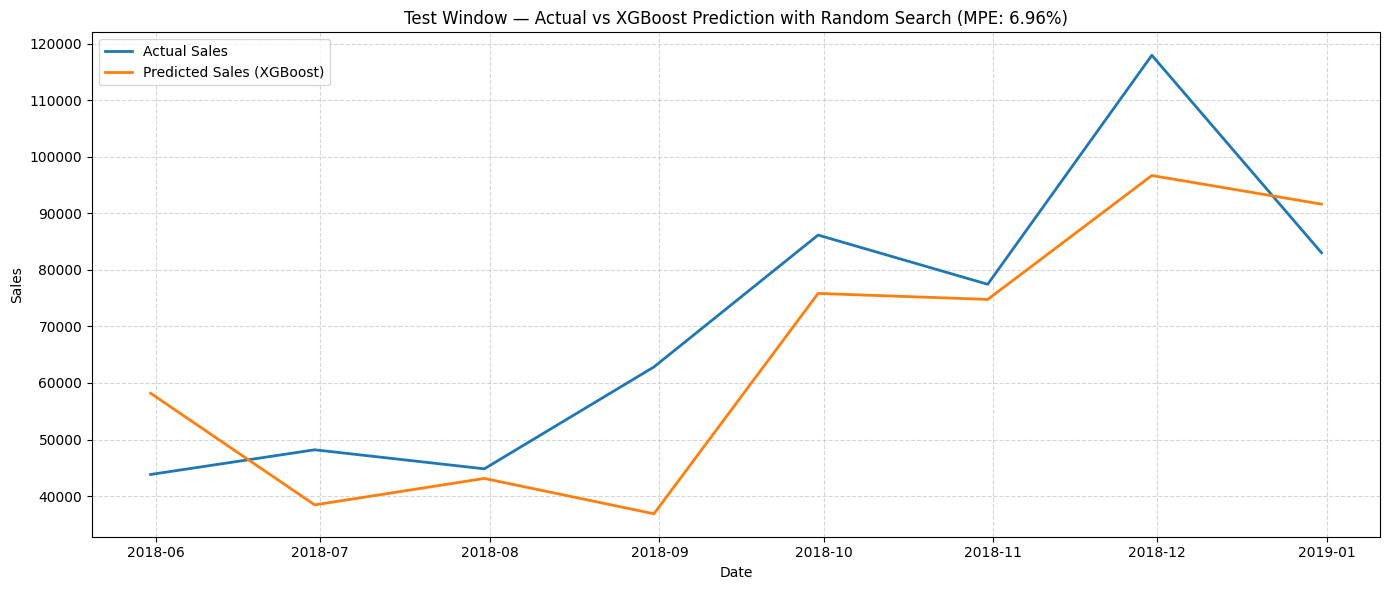

In [51]:
sales_xgb = sales_ppt.copy().sort_values("ds").reset_index(drop=True)
sales_xgb["log_y"] = np.log1p(sales_xgb["y"]) #log transformation

sales_xgb["year"] = sales_xgb["ds"].dt.year
sales_xgb["month"] = sales_xgb["ds"].dt.month
sales_xgb["quarter"] = sales_xgb["ds"].dt.quarter

sales_xgb["lag_1"] = sales_xgb["y"].shift(1)
sales_xgb["lag_2"] = sales_xgb["y"].shift(2)
sales_xgb["lag_3"] = sales_xgb["y"].shift(3)
sales_xgb["lag_6"] = sales_xgb["y"].shift(6)
sales_xgb["lag_12"] = sales_xgb["y"].shift(12)

sales_xgb["roll_std_3"] = sales_xgb["y"].shift(1).rolling(3).std()


features = ["year",
            "month",
            "quarter",
            "lag_1", "lag_12",
            "lag_3", "lag_6",
            "lag_2",
            "roll_std_3"]

sales_xgb = sales_xgb.dropna().reset_index(drop=True)

split = int(len(sales_xgb) * 0.8)
train_xgb = sales_xgb.iloc[:split]
test_xgb = sales_xgb.iloc[split:]

X_train = train_xgb[features]
y_train = train_xgb["log_y"]

X_test = test_xgb[features]
y_test = test_xgb["log_y"]

tscv = TimeSeriesSplit(n_splits=3) 

param_grid = {"n_estimators": [300, 600, 1000, 1500],
              "learning_rate": [0.01, 0.03, 0.05, 0.1],
              "max_depth": [3, 4, 5, 6, 8],
              "min_child_weight": [1, 2, 5, 10],
              "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
              "colsample_bytree": [0.6, 0.7, 0.8, 1.0],
              "gamma": [0, 0.01, 0.1, 0.5],
              "reg_alpha": [0, 0.01, 0.1, 1],
              "reg_lambda": [0.1, 1, 5, 10]}

xgb = XGBRegressor(objective="reg:squarederror", random_state=random_seed)

search = RandomizedSearchCV(estimator=xgb,
                            param_distributions=param_grid,
                            n_iter=30,
                            scoring="neg_mean_absolute_error",
                            cv=tscv,
                            verbose=1,
                            random_state=random_seed,
                            n_jobs=-1)

search.fit(X_train, y_train)

best_model = search.best_estimator_
print("Best params:", search.best_params_)

log_pred = best_model.predict(X_test)
y_pred = np.expm1(log_pred)   
y_true = test_xgb["y"].values

## Evaluation ##
mae_xgb = mean_absolute_error(y_true, y_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_true, y_pred))
mape_xgb = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mpe_xgb = np.mean((y_true - y_pred) / y_true) * 100
print(f"=== Final XGBoost Results with RS HPO (80/20 Split) ===")
print(f"MAE : {mae_xgb:,.2f}")
print(f"RMSE: {rmse_xgb:,.2f}")
print(f"MAPE: {mape_xgb:.2f}%")
print(f"MPE: {mpe_xgb:.2f}%")

## Plot ##
plt.figure(figsize=(14,6))
plt.plot(test_xgb["ds"], y_true, label="Actual Sales", linewidth=2)
plt.plot(test_xgb["ds"], y_pred, label="Predicted Sales (XGBoost)", linewidth=2)
plt.title("Test Window — Actual vs XGBoost Prediction with Random Search (MPE: 6.96%)")
plt.xlabel("Date"); plt.ylabel("Sales"); plt.legend(); plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout(); plt.show()

## HYBRID MODEL BUILDING

### Baseline Prophet-XGBoost Hybrid ###

20:21:37 - cmdstanpy - INFO - Chain [1] start processing
20:21:37 - cmdstanpy - INFO - Chain [1] done processing


=== Baseline Hybrid: Prophet + XGB (Residual) Results ===
MAE : 11,512.98
RMSE: 13,638.07
MAPE: 17.36%
MPE : 6.81%


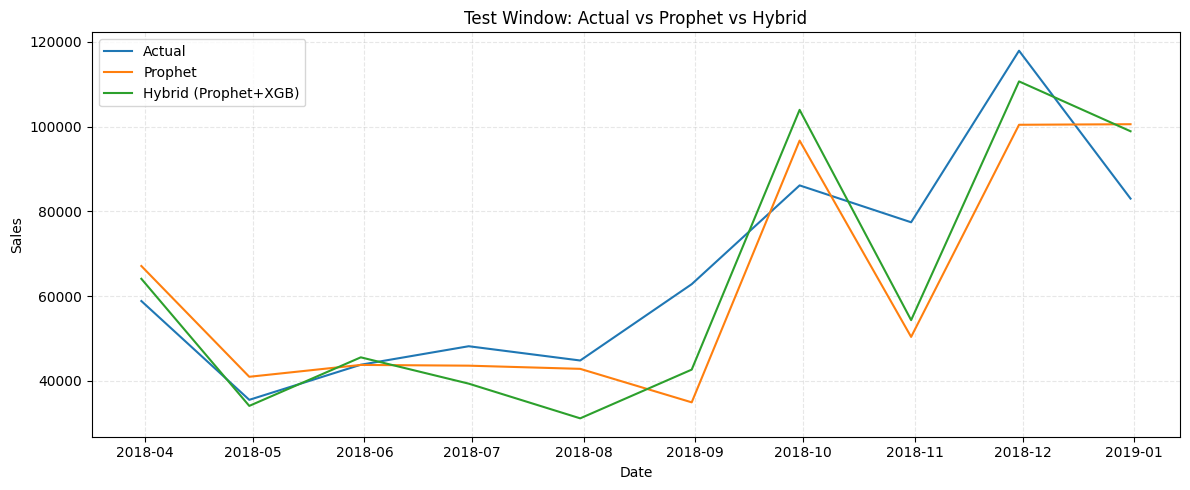

In [61]:
sales_hbd = sales_ppt.sort_values("ds").reset_index(drop=True)

split = int(len(sales_hbd) * 0.8)
train_hbd = sales_hbd.iloc[:split].copy()
test_hbd  = sales_hbd.iloc[split:].copy()


hybrid_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.09)
hybrid_model.fit(train_hbd[["ds","y"]])

all_dates = pd.concat([train_hbd[["ds"]], test_hbd[["ds"]]], axis=0)
fcst_all = hybrid_model.predict(all_dates)


fcst_all = fcst_all[["ds","yhat"]].rename(columns={"yhat":"yhat_p"})
train_hbd = train_hbd.merge(fcst_all, on="ds", how="left")
test_hbd  = test_hbd.merge(fcst_all, on="ds", how="left")

train_hbd["resid"] = train_hbd["y"] - train_hbd["yhat_p"]

lags = (1,2,3,6,12)

def add_resid_lags(df, col="resid", lags=lags):
    df = df.copy()
    for L in lags:
        df[f"{col}_lag{L}"] = df[col].shift(L)
    return df


train_feat = add_resid_lags(train_hbd, "resid", lags=lags).dropna().copy()

resid_features = [f"resid_lag{L}" for L in lags] + ["yhat_p"]  
X_train = train_feat[resid_features]
y_train = train_feat["resid"]

xgb_res = XGBRegressor(n_estimators=800,
                       learning_rate=0.03,
                       max_depth=4,
                       subsample=0.8,
                       colsample_bytree=0.8,
                       random_state=random_seed,
                       objective="reg:squarederror")
xgb_res.fit(X_train, y_train)

test_hbd = test_hbd.copy()
test_hbd["resid_pred"] = np.nan

# history of residuals we are allowed to use = training residuals
resid_history = train_hbd["resid"].tolist()

for i in range(len(test_hbd)):
    row = test_hbd.iloc[i]

    feat = {"yhat_p": row["yhat_p"]}
    for L in lags:
        feat[f"resid_lag{L}"] = resid_history[-L]  # last L residuals (predicted as we go)

    X_one = pd.DataFrame([feat])[resid_features]
    r_hat = xgb_res.predict(X_one)[0]

    test_hbd.loc[test_hbd.index[i], "resid_pred"] = r_hat
    resid_history.append(r_hat) 

    test_hbd["yhat_hybrid"] = test_hbd["yhat_p"] + test_hbd["resid_pred"]

y_true_hbd = test_hbd["y"].values
y_pred_hbd = test_hbd["yhat_hybrid"].values

## Evaluation

mae  = mean_absolute_error(y_true_hbd, y_pred_hbd)
rmse = np.sqrt(mean_squared_error(y_true_hbd, y_pred_hbd))
mape = np.mean(np.abs((y_true_hbd - y_pred_hbd) / y_true_hbd)) * 100
mpe  = np.mean((y_true_hbd - y_pred_hbd) / y_true_hbd) * 100
print("=== Baseline Hybrid: Prophet + XGB (Residual) Results ===")
print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"MPE : {mpe:.2f}%")

## Plot ##

plt.figure(figsize=(12,5))
plt.plot(test_hbd["ds"], test_hbd["y"], label="Actual")
plt.plot(test_hbd["ds"], test_hbd["yhat_p"], label="Prophet")
plt.plot(test_hbd["ds"], test_hbd["yhat_hybrid"], label="Hybrid (Prophet+XGB)")
plt.title("Test Window: Actual vs Prophet vs Hybrid")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.3); plt.tight_layout();plt.show()

### Hybrid (Only Prophet Feature Engineering) ###

20:19:48 - cmdstanpy - INFO - Chain [1] start processing
20:19:48 - cmdstanpy - INFO - Chain [1] done processing


=== Hybrid: Prophet + XGB (Residual) Results ===
**features only engineered within Prophet
MAE : 9,866.56
RMSE: 11,979.08
MAPE: 14.86%
MPE : 1.65%


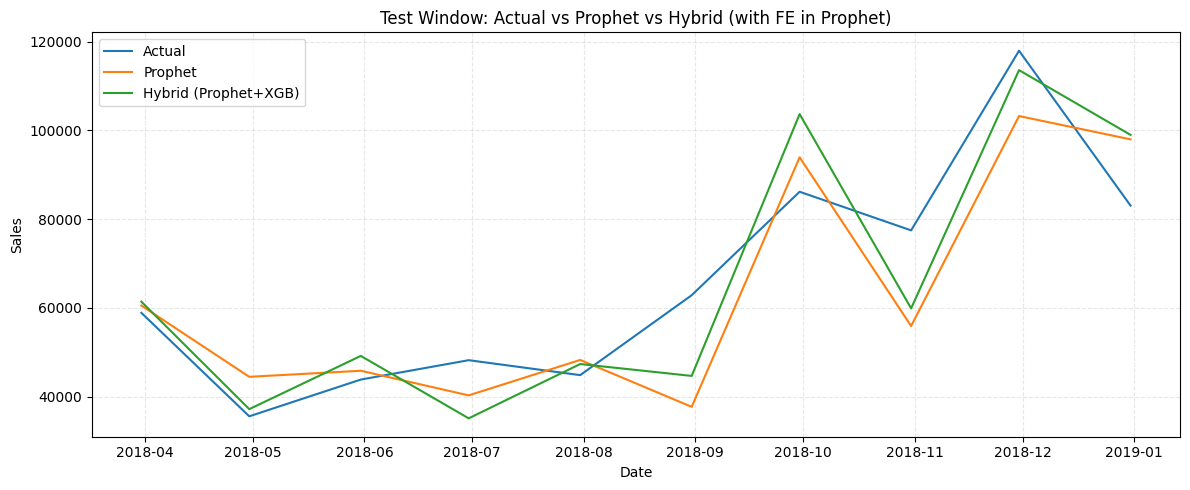

In [53]:
sales_hbd = sales_ppt.sort_values("ds").reset_index(drop=True)

sales_hbd["month"] = sales_hbd["ds"].dt.month
sales_hbd["year"] = sales_hbd["ds"].dt.year   
sales_hbd["is_september"] = (sales_hbd["month"] == 9).astype(int)
sales_hbd["is_november"] = (sales_hbd["month"] == 11).astype(int)
sales_hbd["is_december"] = (sales_hbd["month"] == 12).astype(int)
sales_hbd["is_january"] = (sales_hbd["month"] == 1).astype(int)

split = int(len(sales_hbd) * 0.8)
train_hbd = sales_hbd.iloc[:split].copy()
test_hbd  = sales_hbd.iloc[split:].copy()


hybrid_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.09)

hybrid_model.add_seasonality(
    name="quarterly",
    period=91.25, #365.25/4
    fourier_order=2) #conrtroling how complex the seasonl pattern is allowed to be

hybrid_model.add_regressor("is_september",mode="multiplicative")
hybrid_model.add_regressor("is_november",mode="multiplicative")
hybrid_model.add_regressor("is_december",mode="multiplicative")
hybrid_model.add_regressor("is_january",mode="additive")

hybrid_model.fit(train_hbd[["ds","y", "is_september","is_november","is_december", "is_january"]])

all_dates = pd.concat([train_hbd[["ds", "is_september","is_november","is_december", "is_january"]], 
                       test_hbd[["ds", "is_september","is_november","is_december", "is_january"]]], axis=0)
fcst_all = hybrid_model.predict(all_dates)


fcst_all = fcst_all[["ds","yhat"]].rename(columns={"yhat":"yhat_p"})
train_hbd = train_hbd.merge(fcst_all, on="ds", how="left")
test_hbd  = test_hbd.merge(fcst_all, on="ds", how="left")

train_hbd["resid"] = train_hbd["y"] - train_hbd["yhat_p"]

lags = (1,2,3,6,12)
def add_resid_lags(df, col="resid", lags=lags):
    df = df.copy()
    for L in lags:
        df[f"{col}_lag{L}"] = df[col].shift(L)
    return df

train_feat = add_resid_lags(train_hbd, "resid", lags=lags).dropna().copy()

resid_features = [f"resid_lag{L}" for L in lags] + ["yhat_p"] 
X_train = train_feat[resid_features]
y_train = train_feat["resid"]

xgb_res = XGBRegressor(n_estimators=800,
                       learning_rate=0.03,
                       max_depth=4,
                       subsample=0.8,
                       colsample_bytree=0.8,
                       random_state=random_seed,
                       objective="reg:squarederror")
xgb_res.fit(X_train, y_train)

test_hbd = test_hbd.copy()
test_hbd["resid_pred"] = np.nan

resid_history = train_hbd["resid"].tolist()

for i in range(len(test_hbd)):
    row = test_hbd.iloc[i]

    feat = {"yhat_p": row["yhat_p"]}
    for L in lags:
        feat[f"resid_lag{L}"] = resid_history[-L]

    X_one = pd.DataFrame([feat])[resid_features]
    r_hat = xgb_res.predict(X_one)[0]

    test_hbd.loc[test_hbd.index[i], "resid_pred"] = r_hat
    resid_history.append(r_hat) 

test_hbd["yhat_hybrid"] = test_hbd["yhat_p"] + test_hbd["resid_pred"]

y_true = test_hbd["y"].values
y_pred = test_hbd["yhat_hybrid"].values

## Evaluation ##

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mpe  = np.mean((y_true - y_pred) / y_true) * 100
print("=== Hybrid: Prophet + XGB (Residual) Results ===")
print("**features only engineered within Prophet")
print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"MPE : {mpe:.2f}%")

## Plot ##

plt.figure(figsize=(12,5))
plt.plot(test_hbd["ds"], test_hbd["y"], label="Actual")
plt.plot(test_hbd["ds"], test_hbd["yhat_p"], label="Prophet")
plt.plot(test_hbd["ds"], test_hbd["yhat_hybrid"], label="Hybrid (Prophet+XGB)")
plt.title("Test Window: Actual vs Prophet vs Hybrid (with FE in Prophet)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.3); plt.tight_layout();plt.show()

## Final Hybrid Model ##

>> Features accordingly engineered within Prophet and XGBooost

>> Temporal Split: Row-based 80/20

>> Random Search HPO

20:21:44 - cmdstanpy - INFO - Chain [1] start processing
20:21:44 - cmdstanpy - INFO - Chain [1] done processing


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best XGB params: {'subsample': 0.9, 'reg_lambda': 5, 'reg_alpha': 0.01, 'n_estimators': 600, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
=== Final Hybrid: Prophet + XGB (Residual) Results ===
MAE : 9,863.65
RMSE: 11,959.81
MAPE: 14.74%
MPE : 1.98%


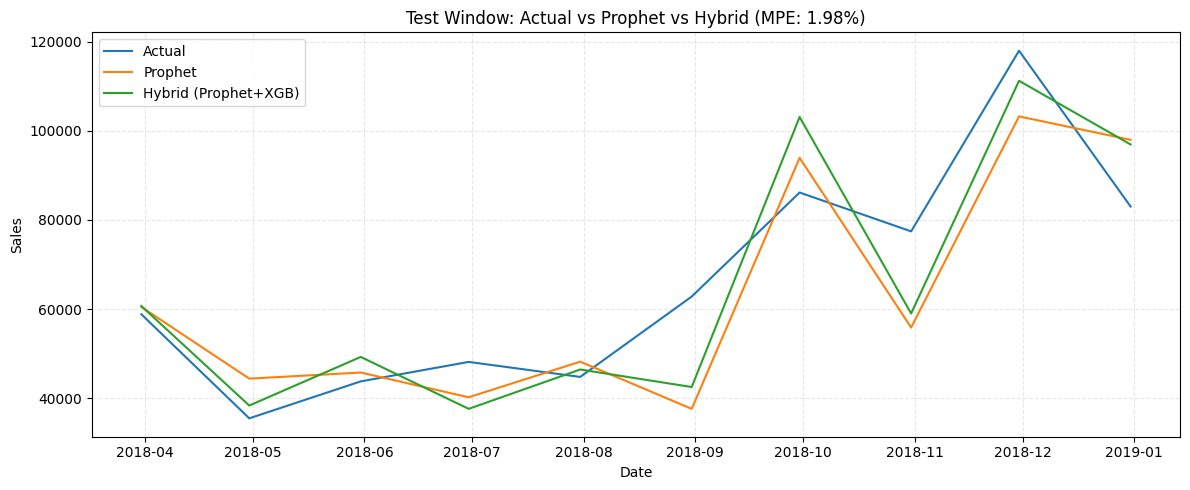

In [62]:
sales_hbd = sales_ppt.sort_values("ds").reset_index(drop=True)

sales_hbd["month"] = sales_hbd["ds"].dt.month
sales_hbd["year"] = sales_hbd["ds"].dt.year   
sales_hbd["is_september"] = (sales_hbd["month"] == 9).astype(int)
sales_hbd["is_november"] = (sales_hbd["month"] == 11).astype(int)
sales_hbd["is_december"] = (sales_hbd["month"] == 12).astype(int)
sales_hbd["is_january"] = (sales_hbd["month"] == 1).astype(int)

split = int(len(sales_hbd) * 0.8)
train_hbd = sales_hbd.iloc[:split].copy()
test_hbd  = sales_hbd.iloc[split:].copy()


hybrid_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.09)

hybrid_model.add_seasonality(
    name="quarterly",
    period=91.25, #365.25/4
    fourier_order=2)

hybrid_model.add_regressor("is_september",mode="multiplicative")
hybrid_model.add_regressor("is_november",mode="multiplicative")
hybrid_model.add_regressor("is_december",mode="multiplicative")
hybrid_model.add_regressor("is_january",mode="additive")

hybrid_model.fit(train_hbd[["ds","y", "is_september","is_november","is_december", "is_january"]])

all_dates = pd.concat([train_hbd[["ds", "is_september","is_november","is_december", "is_january"]], 
                       test_hbd[["ds", "is_september","is_november","is_december", "is_january"]]], axis=0)
fcst_all = hybrid_model.predict(all_dates)


fcst_all = fcst_all[["ds","yhat"]].rename(columns={"yhat":"yhat_p"})
train_hbd = train_hbd.merge(fcst_all, on="ds", how="left") #mergeing actual and forecasted to feed to XGB
test_hbd = test_hbd.merge(fcst_all, on="ds", how="left")

train_hbd["resid"] = train_hbd["y"] - train_hbd["yhat_p"]


## XGB RESD TRAINING 
lags = (1, 2, 3, 6, 12)
def add_resid_features(df):
    df = df.copy()
    # residual lags
    for L in lags:
        df[f"resid_lag{L}"] = df["resid"].shift(L)
    df["resid_roll_std_3"]  = df["resid"].shift(1).rolling(3).std()
    df["year"] = df["ds"].dt.year
    df["month"] = df["ds"].dt.month
    df["quarter"] = df["ds"].dt.quarter
    return df

train_feat = add_resid_features(train_hbd).dropna().copy()

resid_features = ["resid_lag1","resid_lag2","resid_lag3","resid_lag6","resid_lag12",
                  "resid_roll_std_3",
                  "year",
                  "month","quarter",
                  "yhat_p"]  # Prophet baseline as anchor

X_train = train_feat[resid_features]
y_train = train_feat["resid"]

param_dist = {"n_estimators": [200, 400, 600, 800],
              "learning_rate": [0.01, 0.03, 0.05],
              "max_depth": [2, 3, 4],
              "min_child_weight": [1, 3, 5],
              "subsample": [0.7, 0.8, 0.9],
              "colsample_bytree": [0.7, 0.8, 0.9],
              "reg_alpha": [0, 0.01, 0.1, 1], #L1 regularisation
              "reg_lambda": [0.1, 1, 5, 10]} #L2 regularisation


tscv = TimeSeriesSplit(n_splits=3)

xgb_base = XGBRegressor(objective="reg:squarederror", random_state=random_seed)
rand_search = RandomizedSearchCV(estimator=xgb_base,
                                 param_distributions=param_dist,
                                 n_iter=20,              
                                 scoring="neg_mean_absolute_error",
                                 cv=tscv,
                                 verbose=1,
                                 random_state=random_seed,
                                 n_jobs=-1)

rand_search.fit(X_train, y_train)
best_xgb = rand_search.best_estimator_
print("Best XGB params:", rand_search.best_params_)


test_hbd = test_hbd.copy()
test_hbd["resid_pred"] = np.nan
resid_history = train_hbd["resid"].tolist()

for i in range(len(test_hbd)):
    row = test_hbd.iloc[i]

    # base features
    feat = {"yhat_p": row["yhat_p"],
            "year": row["ds"].year,
            "month": row["ds"].month,
            "quarter": row["ds"].quarter,
            "resid_roll_std_3": np.std(resid_history[-3:], ddof=1) if len(resid_history) >= 3 else 0.0}

    #residual lags 
    for L in lags:
        feat[f"resid_lag{L}"] = resid_history[-L]
    X_one = pd.DataFrame([feat])[resid_features]
    r_hat = best_xgb.predict(X_one)[0] # predict residual
    test_hbd.loc[test_hbd.index[i], "resid_pred"] = r_hat # store + roll forward
    resid_history.append(r_hat)

test_hbd["yhat_hybrid"] = test_hbd["yhat_p"] + test_hbd["resid_pred"]

y_true = test_hbd["y"].values
y_pred = test_hbd["yhat_hybrid"].values

## Evaluation ##

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mpe  = np.mean((y_true - y_pred) / y_true) * 100
print("=== Final Hybrid: Prophet + XGB (Residual) Results ===")
print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"MPE : {mpe:.2f}%")

## Plot ##

plt.figure(figsize=(12,5))
plt.plot(test_hbd["ds"], test_hbd["y"], label="Actual")
plt.plot(test_hbd["ds"], test_hbd["yhat_p"], label="Prophet")
plt.plot(test_hbd["ds"], test_hbd["yhat_hybrid"], label="Hybrid (Prophet+XGB)")
plt.title("Test Window: Actual vs Prophet vs Hybrid (MPE: 1.98%)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.3); plt.tight_layout();plt.show()

## Residual Diagnostic ##

In [55]:
test_hbd["resid_true"] = test_hbd["y"] - test_hbd["yhat_p"] #errors from prophet
resid_true = test_hbd["resid_true"].values
resid_pred = test_hbd["resid_pred"].values

eps = 1e-6
mask = np.abs(resid_true) > eps

mae_resid  = mean_absolute_error(resid_true, resid_pred)
rmse_resid = np.sqrt(mean_squared_error(resid_true, resid_pred))
mape_resid = np.mean(np.abs((resid_true[mask] - resid_pred[mask]) / resid_true[mask])) * 100
mpe_resid = np.mean((resid_true[mask] - resid_pred[mask]) / resid_true[mask]) * 100

corr = np.corrcoef(resid_true, resid_pred)[0, 1]
directional_acc = np.mean(np.sign(resid_true) == np.sign(resid_pred))

print(f"Directional accuracy: {directional_acc:.2%}")
print(f"Residual correlation: {corr:.3f}")
print(f"Residual MAPE: {mape_resid:.2f}%")
print(f"Residual MPE : {mpe_resid:.2f}%")
print(f"Residual MAE : {mae_resid:,.2f}")
print(f"Residual RMSE: {rmse_resid:,.2f}")

Directional accuracy: 60.00%
Residual correlation: 0.390
Residual MAPE: 112.54%
Residual MPE : 112.54%
Residual MAE : 9,863.65
Residual RMSE: 11,959.81


### True residual vs  predicted graph ##

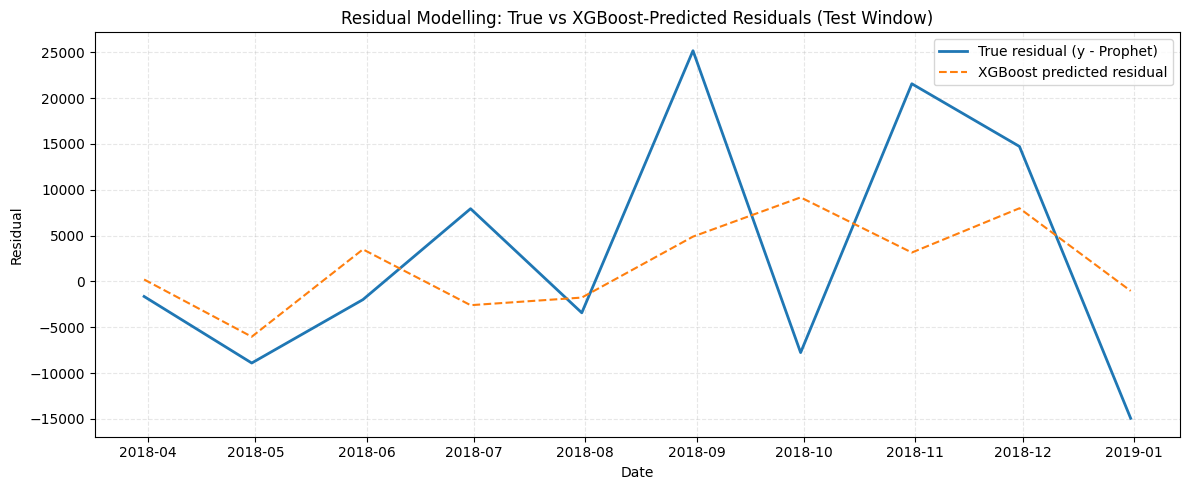

In [56]:
plt.figure(figsize=(12,5))
plt.plot(test_hbd["ds"], test_hbd["resid_true"], label="True residual (y - Prophet)", linewidth=2)
plt.plot(test_hbd["ds"], test_hbd["resid_pred"], label="XGBoost predicted residual", linestyle="--")

plt.title("Residual Modelling: True vs XGBoost-Predicted Residuals (Test Window)")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.3); plt.tight_layout();plt.show()

### Statistical Residual Summary

In [57]:
if "resid_pred" not in test_hbd.columns:
    print("CRITICAL: resid_pred was never created. Re-run for loop cell.")
else:
    print("=== Statistical Summary of Residuals ===")
    print(f"True Residuals (Prophet Error):\n{test_hbd['resid_true'].describe()}\n")
    print(f"Predicted Residuals (XGBoost Correction):\n{test_hbd['resid_pred'].describe()}")

=== Statistical Summary of Residuals ===
True Residuals (Prophet Error):
count       10.000000
mean      3072.941636
std      13597.035627
min     -14932.829607
25%      -6679.251014
50%      -1811.889950
75%      13024.092092
max      25162.884559
Name: resid_true, dtype: float64

Predicted Residuals (XGBoost Correction):
count      10.000000
mean     1747.272720
std      4836.079213
min     -6029.849609
25%     -1579.574799
50%      1679.736221
75%      4539.495483
max      9165.726562
Name: resid_pred, dtype: float64
